# Import

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# reward_mosse
per ogni partita ho il numero di mosse e le reward finali

[42.0, 45.0, 45.0, 19.5, 22.5, 31.5, 17.75, 40.25, 29.892857142857142, 30.392857142857142, 42.94285714285714, 12.567857142857143, 15.267857142857142, 19.68452380952381, 26.041666666666668, 4.923160173160173, 22.528846153846153, 16.391941391941394, 2.5, 25.40384615384615, 1.1934523809523805, 2.674019607843137, 2.0258373205741624, 1.492533696094068, 2.3786688233619255, 2.7753357753357752, 12.02097829071514, 1.2803030303030303, 2.221229126835533, 2.2261706079764148, 2.4039852737258074, 0.7019866003561601, 0.755600649350649, 1.4420120320855618, 1.0374211757039096, 1.3937010133941075, 1.996322293358936, 1.0329863934515089, 2.8595571095571084, 2.369148212898213, 2.212057367949009, 2.9631832669127056, 0.26972397129846515]
[0, 0, 0, 0, 0, 3.0, 0.0, 1.75, 0.1071428571428572, 1.1071428571428572, 3.5571428571428574, 4.232142857142858, 6.932142857142857, 5.958333333333333, 10.315476190476192, 12.826839826839828, 9.471153846153847, 13.60805860805861, 19.73901098901099, 16.596153846153847, 32.417073

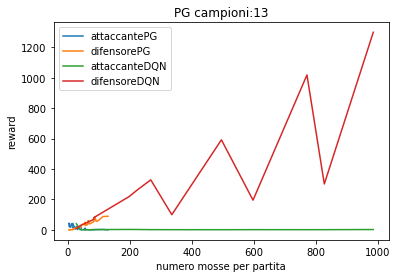

In [90]:
pg = {'attaccante': [(3, 45.0), (55, 2.3786688233619255), (15, 29.892857142857142), (5, 22.5), (65, 0.755600649350649), (49, 2.674019607843137), (55, 1.492533696094068), (3, 42.0), (55, 12.02097829071514), (91, 2.369148212898213), (73, 1.3937010133941075), (15, 42.94285714285714), (57, 1.2803030303030303), (15, 30.392857142857142), (23, 4.923160173160173), (51, 2.0258373205741624), (87, 1.0329863934515089), (65, 0.7019866003561601), (17, 12.567857142857143), (55, 2.7753357753357752), (5, 31.5), (43, 1.1934523809523805), (83, 1.996322293358936), (67, 1.4420120320855618), (11, 40.25), (27, 22.528846153846153), (9, 17.75), (19, 26.041666666666668), (89, 2.8595571095571084), (3, 45.0), (57, 2.221229126835533), (19, 19.68452380952381), (31, 2.5), (41, 25.40384615384615), (29, 16.391941391941394), (59, 2.2261706079764148), (17, 15.267857142857142), (113, 2.9631832669127056), (99, 2.212057367949009), (129, 0.26972397129846515), (5, 19.5), (69, 1.0374211757039096), (63, 2.4039852737258074)], 'difensore': [(3, 0), (55, 50.944408099715), (15, 0.1071428571428572), (5, 0), (65, 53.333605305984335), (49, 38.738741544048445), (55, 35.40746630390593), (3, 0), (55, 36.479021709284865), (91, 55.689810158640384), (73, 42.53983873314968), (15, 3.5571428571428574), (57, 39.564935064935064), (15, 1.1071428571428572), (23, 12.826839826839828), (51, 35.08585735729698), (87, 87.55584531457184), (65, 61.5891424319019), (17, 6.932142857142857), (55, 38.57249031162075), (5, 3.0), (43, 32.41707393483709), (83, 53.59827230123566), (67, 59.81123459021732), (11, 1.75), (27, 9.471153846153847), (9, 0.0), (19, 5.958333333333333), (89, 69.12591653158043), (3, 0), (57, 27.778770873164465), (19, 10.315476190476192), (31, 19.73901098901099), (41, 16.596153846153847), (29, 13.60805860805861), (59, 36.17382939202358), (17, 4.232142857142858), (113, 88.14320829159757), (99, 62.70338469800344), (129, 89.5452472826189), (5, 0), (69, 38.94533744498575), (63, 34.0960147262742)]}

dqn = {'attaccante': [(597, 1.6868910517943085), (39, 1.4447767145135568), (335, 1.5335297342302), (827, 1.5711452911787191), (495, 1.3168896765981652), (985, 2.47879270688406), (83, 0.6294906789831088), (225, 2.6832782272294433), (83, 2.210531044274346), (27, 40.684149184149184), (267, 1.7866243181595212), (771, 1.5077019720375626), (197, 2.9572972795197816)], 'difensore': [(597, 195.51877077827407), (39, 27.426762285701912), (335, 99.99672121183178), (827, 301.83214417472345), (495, 591.8158327559734), (985, 1298.3043968665181), (83, 69.26770833518573), (225, 264.6999208916892), (83, 80.23317467046125), (27, 8.565850815850816), (267, 328.79423008127776), (771, 1017.7463793680523), (197, 218.6527441109585)]}

""" x = []
y = []
a.sort()
print(a)
for i in a :
    x.append(i[0])
    y.append(i[1])
print(x)
print(y)

plt.ylabel('reward attaccante')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()

x = []
y = []

print(b)
for i in b :
    x.append(i[0])
    y.append(i[1])
print(x)
print(y)
plt.title('PG campioni:'+str(len(x)))
plt.ylabel('reward difensore')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()
 """
################# PG ##################
b = pg['difensore']
b.sort()
a = pg['attaccante']
a.sort()

xA = []
yA = []
xB = []
yB = []
mosseMax = 0
for i in range(len(a)) :
    xA.append(a[i][1])
    yA.append(a[i][0])
    xB.append(b[i][1])
    yB.append(b[i][0])

print(xA)
print(xB)
plt.plot(yA,xA)
plt.plot(yB,xB)

################ DQN ####################
b = dqn['difensore']
b.sort()
a = dqn['attaccante']
a.sort()

xA = []
yA = []
xB = []
yB = []
mosseMax = 0
for i in range(len(a)) :
    xA.append(a[i][1])
    yA.append(a[i][0])
    xB.append(b[i][1])
    yB.append(b[i][0])

print(xA)
print(xB)
plt.title('PG campioni:'+str(len(xA)))
plt.ylabel('reward')
plt.xlabel('numero mosse per partita')
plt.plot(yA,xA)
plt.plot(yB,xB)
plt.legend(['attaccantePG','difensorePG','attaccanteDQN','difensoreDQN'])

plt.show()

# reward_mosse
ma con piu epoche

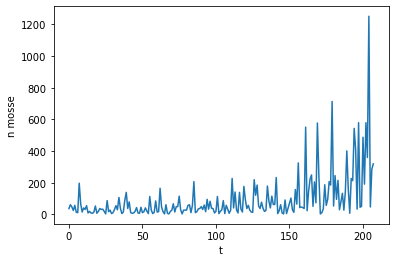

208
208


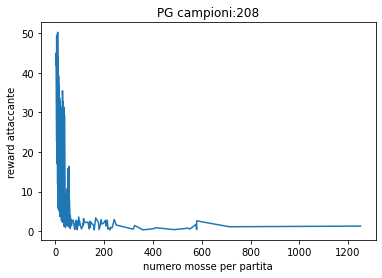

208
208


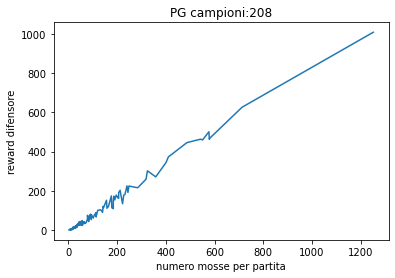

208
208


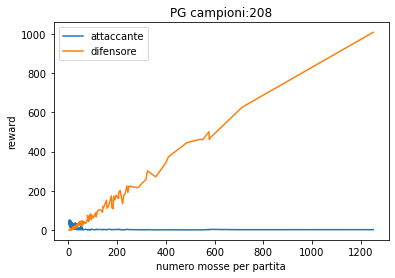

In [87]:
d ={'attaccante': [(37, 26.315960999784526), (61, 0.6823529411764704), (47, 1.9690506637437584), (25, 2.6428571428571423), (57, 2.3333142639206743), (13, 39.25), (11, 5.75), (197, 1.9759779374899744), (67, 1.8516302776171187), (15, 23.892857142857142), (41, 8.006493506493506), (31, 8.214285714285714), (55, 1.9953823953823948), (9, 28.25), (19, 3.666666666666667), (9, 20.75), (7, 26.0), (15, 5.142857142857142), (53, 1.2557045895281185), (7, 30.5), (19, 32.791666666666664), (37, 16.25), (31, 32.744588744588754), (33, 21.7092032967033), (19, 25.541666666666668), (3, 45.0), (87, 0.8443974681453189), (17, 7.767857142857142), (27, 14.267482517482517), (5, 49.5), (11, 39.75), (31, 15.696428571428571), (55, 16.380230880230886), (29, 3.2555777555777556), (107, 0.5679815616495514), (39, 9.417449874686717), (5, 46.5), (15, 21.192857142857143), (89, 0.3619098687156766), (139, 0.5909055567865117), (37, 13.474614845938378), (79, 1.810889682213215), (11, 32.0), (7, 21.5), (9, 11.75), (19, 16.291666666666668), (43, 1.8755411255411247), (9, 50.25), (7, 23.0), (45, 1.877299783549783), (11, 27.75), (17, 33.625), (41, 1.5394736842105263), (21, 23.416666666666668), (5, 22.5), (113, 1.5625905797101445), (27, 6.903846153846153), (5, 34.5), (13, 32.25), (85, 1.7244137441505873), (15, 21.892857142857142), (17, 12.017857142857142), (165, 3.3581514736923848), (47, 1.6619078066009012), (17, 21.375), (3, 42.0), (61, 2.6156968031968026), (7, 21.5), (3, 42.0), (19, 24.80952380952381), (27, 23.703846153846154), (67, 1.5812425873503964), (15, 13.642857142857142), (49, 1.380357142857143), (49, 2.061206696117182), (115, 1.5998769092590666), (29, 2.2847985347985347), (3, 42.0), (27, 28.3984348984349), (27, 28.070512820512818), (27, 23.892482517482517), (57, 2.4965728715728708), (61, 0.7719719428644436), (11, 20.25), (57, 1.0197988286223572), (207, 2.688413591863905), (11, 35.75), (17, 24.875), (35, 1.2633053221288506), (37, 14.682032428355958), (49, 3.4529220779220777), (31, 14.839285714285714), (59, 4.634182771251737), (17, 22.875), (95, 3.5866829260507527), (33, 14.729166666666668), (83, 0.8414987672118849), (39, 2.0051599587203306), (37, 7.609744422244421), (9, 30.75), (19, 18.541666666666668), (113, 2.0288813353828887), (5, 34.5), (19, 22.291666666666668), (29, 23.071428571428573), (87, 1.0780565786426615), (5, 22.5), (57, 8.019761150367556), (33, 22.37256493506494), (7, 17.0), (27, 31.346703296703296), (227, 0.7700507322773062), (41, 0.9529220779220795), (141, 2.493086289533253), (27, 24.528846153846153), (9, 49.25), (139, 1.1124800433004332), (33, 9.961309523809526), (15, 33.892857142857146), (177, 2.114232354658851), (93, 2.638569929382136), (37, 29.30134644766998), (57, 1.4395604395604393), (27, 14.059149184149184), (15, 36.642857142857146), (13, 11.5), (219, 0.86288586881285), (121, 2.1653997202956594), (185, 1.6760484775921511), (53, 1.2497657819588752), (37, 2.630036630036629), (77, 1.3815375414059625), (39, 7.140664160401002), (19, 24.43452380952381), (25, 17.192857142857143), (179, 0.397053299181788), (85, 2.75466505353993), (41, 1.9144736842105265), (115, 3.1968633417250216), (63, 2.914967648838616), (63, 2.416132118109496), (233, 0.9096940113582034), (5, 49.5), (23, 6.806493506493506), (61, 3.8323429444119097), (9, 32.25), (3, 45.0), (91, 1.056159880092807), (5, 49.5), (37, 20.708818142641675), (69, 2.491090837622167), (103, 1.2701505918932308), (29, 16.736638361638363), (13, 8.5), (157, 1.4087518255037461), (65, 1.346947013997918), (325, 1.4332323634179525), (43, 2.3641211729447056), (47, 1.9795548654244302), (43, 2.9642857142857135), (37, 23.26747198879552), (551, 0.5397638860544971), (23, 30.488636363636363), (145, 2.2745360615779284), (223, 0.32738943258512687), (249, 1.5481183314183524), (51, 2.718506493506493), (205, 2.734958610661314), (73, 2.8219662058371724), (577, 1.728830392611192), (241, 2.964924286214072), (3, 42.0), (11, 44.25), (35, 31.36655623787977), (187, 2.886846582419381), (57, 2.700614504174875), (95, 1.4628145333961813), (207, 1.282667110774193), (185, 1.8238314238859168), (713, 1.1157995832365668), (53, 1.2950742111345874), (245, 2.2419212427518582), (95, 1.889064578192118), (215, 0.5445501793112729), (29, 35.49313186813187), (79, 0.42999428886525776), (133, 2.277096233259828), (27, 4.796703296703296), (143, 0.9823328729044953), (401, 0.603574597167801), (159, 0.315384653173869), (7, 48.5), (227, 0.9601434771364713), (213, 2.700509222216803), (543, 0.760775186504971), (411, 0.86401585274501), (33, 18.889506327006327), (579, 0.404429894502865), (45, 9.398287664348036), (51, 15.851671122994654), (487, 0.3844853071530055), (191, 1.8303149097215254), (579, 2.606024104801253), (359, 0.3291024318289222), (1251, 1.2771138679676133), (47, 10.687426818033222), (285, 1.010989268256513), (319, 0.507344847081611)], 'difensore': [(37, 20.184039000215474), (61, 34.96255106785797), (47, 26.408142318712382), (25, 9.357142857142858), (57, 43.01113018052377), (13, 2.75), (11, 0.25), (197, 177.9571015590894), (67, 39.08274124629834), (15, 6.107142857142858), (41, 21.993506493506494), (31, 11.285714285714286), (55, 33.44779942279942), (9, 1.75), (19, 2.333333333333333), (9, 2.25), (7, 4.0), (15, 5.357142857142858), (53, 36.764437110876734), (7, 4.5), (19, 9.208333333333334), (37, 13.749999999999998), (31, 9.255411255411255), (33, 20.290796703296703), (19, 4.458333333333333), (3, 0), (87, 60.26790411915627), (17, 7.232142857142858), (27, 15.732517482517483), (5, 0), (11, 2.25), (31, 19.303571428571427), (55, 25.619769119769117), (29, 7.244422244422244), (107, 75.672958125262), (39, 25.582550125313283), (5, 0), (15, 1.0571428571428574), (89, 64.03868709214788), (139, 93.72492026980592), (37, 21.025385154061624), (79, 57.720360317786785), (11, 1.0), (7, 0), (9, 0), (19, 13.708333333333334), (43, 30.374458874458877), (9, 0.0), (7, 0.0), (45, 28.122700216450216), (11, 2.25), (17, 4.625), (41, 23.49484004127967), (21, 6.583333333333332), (5, 0), (113, 87.46984195278107), (27, 12.596153846153847), (5, 0.0), (13, 2.25), (85, 42.858919589182754), (15, 0.5), (17, 4.982142857142858), (165, 119.51513123877677), (47, 34.33809219339909), (17, 8.625), (3, 0), (61, 38.902350880114035), (7, 0), (3, 0), (19, 5.190476190476191), (27, 12.796153846153846), (67, 32.918757412649605), (15, 1.3571428571428572), (49, 35.243769849076756), (49, 27.188793303882818), (115, 66.15575109636896), (29, 8.465201465201465), (3, 0), (27, 13.601565101565104), (27, 13.929487179487179), (27, 18.107517482517483), (57, 47.60347403378094), (61, 41.22802805713556), (11, 2.25), (57, 46.69303447334138), (207, 190.68666620648372), (11, 1.75), (17, 5.125), (35, 25.30162974280621), (37, 19.817967571644044), (49, 43.575618943749745), (31, 19.660714285714285), (59, 25.365817228748263), (17, 7.125), (95, 52.746208820849716), (33, 19.770833333333336), (83, 44.158501232788126), (39, 24.828173374613005), (37, 22.39025557775558), (9, 3.0), (19, 11.458333333333334), (113, 85.25925038291935), (5, 0.0), (19, 14.208333333333334), (29, 11.428571428571429), (87, 72.92202135375233), (5, 0), (57, 38.48023884963244), (33, 19.627435064935064), (7, 3.0), (27, 10.653296703296704), (227, 170.90736715085526), (41, 33.54707792207792), (141, 89.92900821996729), (27, 14.971153846153847), (9, 0), (139, 93.75385346199971), (33, 20.038690476190478), (15, 0.6071428571428572), (177, 173.5321978095937), (93, 60.73116450285229), (37, 17.198653552330025), (57, 22.549674010200324), (27, 15.940850815850816), (15, 7.357142857142858), (13, 3.5), (219, 161.31815569193742), (121, 99.60432111611726), (185, 108.07771744187215), (53, 41.50023421804112), (37, 20.4876104287869), (77, 48.34437409954775), (39, 22.859335839598998), (19, 6.315476190476191), (25, 12.807142857142857), (179, 112.89345221760622), (85, 46.9931610334166), (41, 32.24715635241951), (115, 69.70694478449452), (63, 35.567790971851046), (63, 40.06662650258017), (233, 181.9208534587665), (5, 0), (23, 10.193506493506494), (61, 41.917657055588094), (9, 2.25), (3, 0), (91, 80.83564863777319), (5, 0), (37, 28.54118185735833), (69, 32.50890916237783), (103, 60.382230360487725), (29, 17.763361638361637), (13, 6.5), (157, 151.45551504102235), (65, 41.55305298600207), (325, 301.6151089262575), (43, 39.63587882705529), (47, 27.617258860065768), (43, 34.6062965994274), (37, 23.23252801120448), (551, 459.1868978819626), (23, 16.011363636363637), (145, 113.81357620194767), (223, 133.57587984754085), (249, 223.85957413517707), (51, 32.422853694293316), (205, 161.34232179907622), (73, 36.571506700566765), (577, 500.8964264262504), (241, 224.79229761823797), (3, 0), (11, 2.25), (35, 17.883443762120233), (187, 172.2191145299277), (57, 42.64382994026957), (95, 78.52133653325704), (207, 161.3757352164142), (185, 146.18769476817192), (713, 626.1585513853439), (53, 40.70492578886541), (245, 191.1650349401323), (95, 57.14501058998315), (215, 186.36901007537907), (29, 11.006868131868133), (79, 74.47009785325474), (133, 102.98897135697251), (27, 10.953296703296704), (143, 120.01111418400637), (401, 343.53190296774574), (159, 110.59621767322207), (7, 0), (227, 176.3152714458388), (213, 202.25294777334992), (543, 463.08273393844075), (411, 372.7806660958023), (33, 15.610493672993677), (579, 462.353458926686), (45, 32.60171233565197), (51, 26.148328877005344), (487, 445.6345028473175), (191, 153.14941047754021), (579, 466.2506005570176), (359, 270.73188725848286), (1251, 1008.8536611891917), (47, 23.812573181966773), (285, 215.17243717242727), (319, 258.61517403898404)]}

a = d['attaccante']
x = []
y = []
for i in a :
    x.append(i[0])
plt.ylabel('n mosse')
plt.xlabel('t')
plt.plot(np.arange(len(x)),x)
plt.show()

x = []
y = []
a.sort()
for i in a :
    x.append(i[0])
    y.append(i[1])
print(len(x))
print(len(y))
plt.title('PG campioni:'+str(len(x)))
plt.ylabel('reward attaccante')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()

x = []
y = []
b = d['difensore']
b.sort()
for i in b :
    x.append(i[0])
    y.append(i[1])
print(len(x))
print(len(y))
plt.title('PG campioni:'+str(len(x)))
plt.ylabel('reward difensore')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()

xA = []
yA = []
xB = []
yB = []
a.sort()
b.sort()
for i in range(len(a)) :
    xA.append(a[i][1])
    yA.append(a[i][0])
    xB.append(b[i][1])
    yB.append(b[i][0])
print(len(xA))
print(len(xB))
plt.title('PG campioni:'+str(len(xA)))
plt.ylabel('reward')
plt.xlabel('numero mosse per partita')
plt.plot(yA,xA)
plt.plot(yB,xB)
plt.legend(['attaccante','difensore'])
plt.show()

# curve partita
Ogni grafico una partita che confronta step by step le reward non ottenute ma le cumulate
Algoritmo PG 100 epoche di training

1922
1922


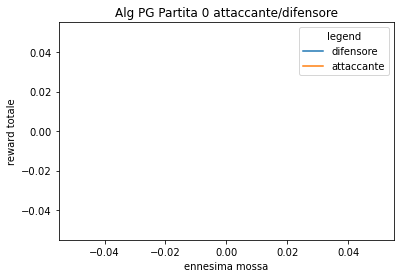

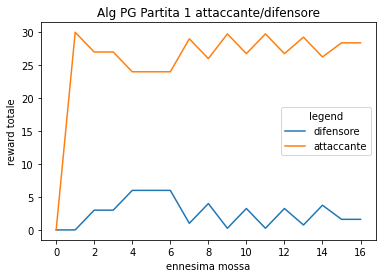

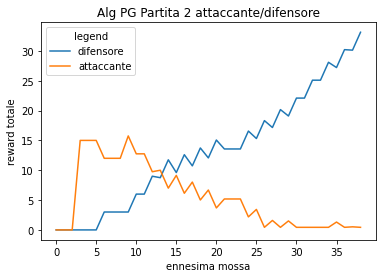

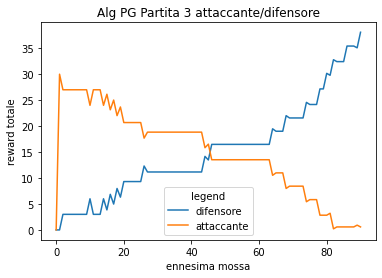

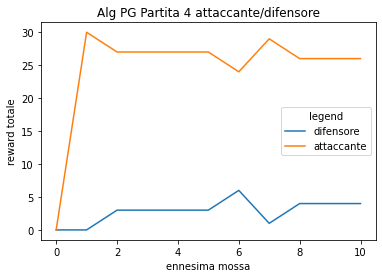

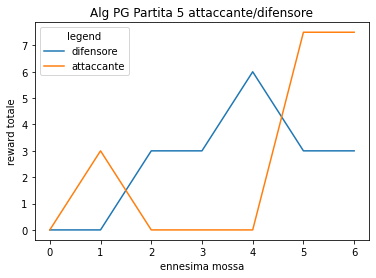

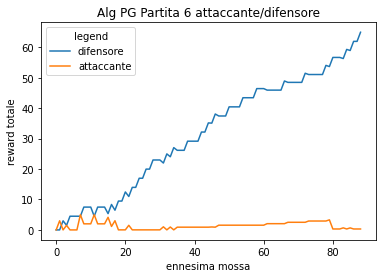

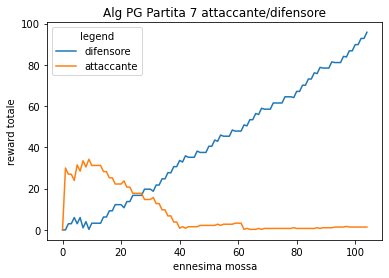

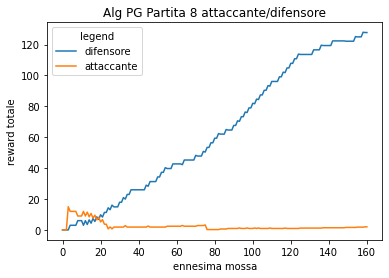

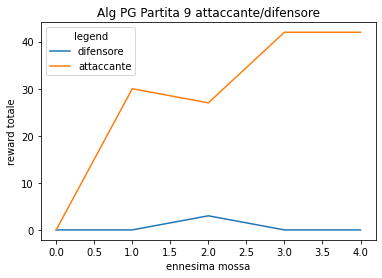

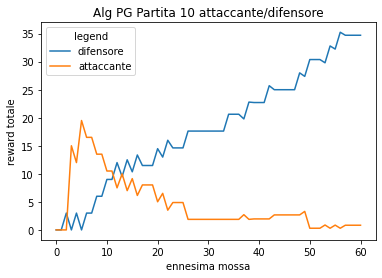

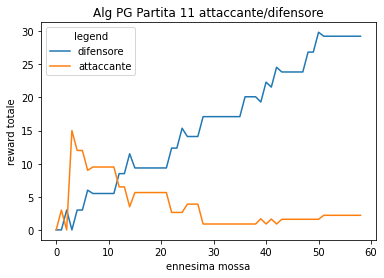

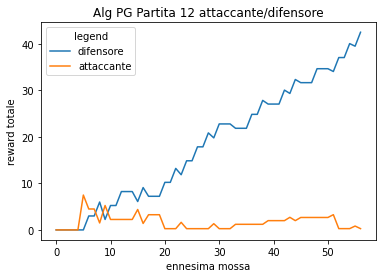

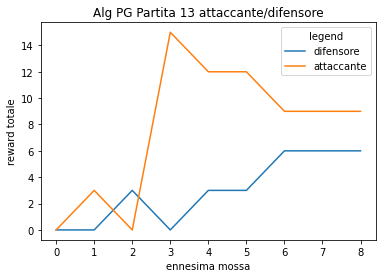

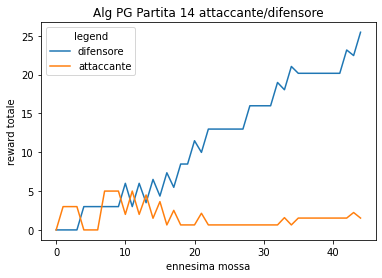

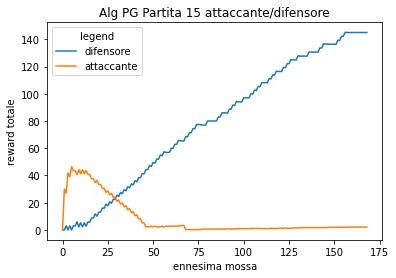

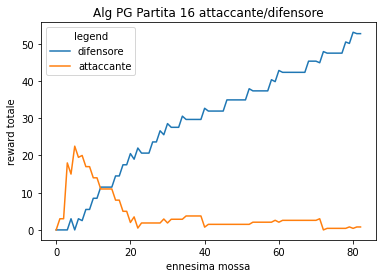

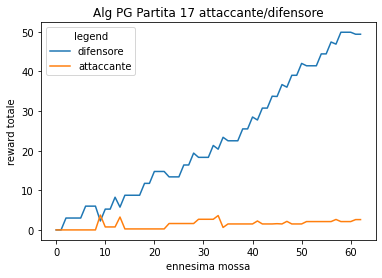

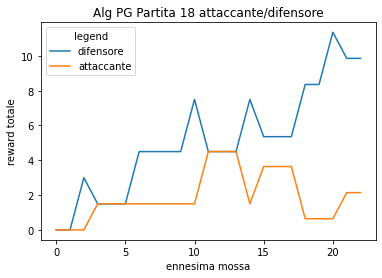

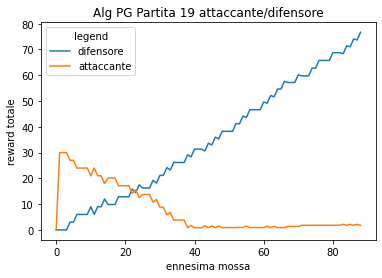

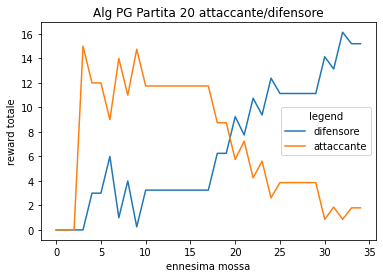

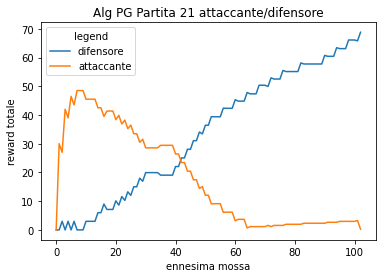

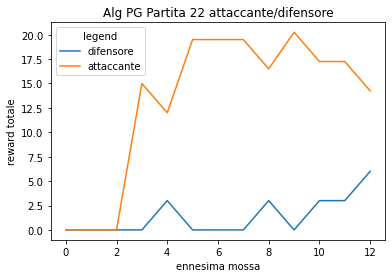

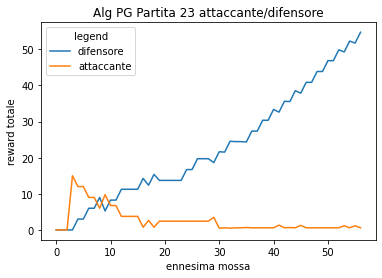

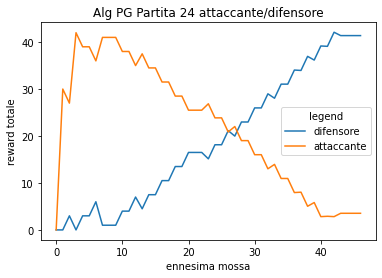

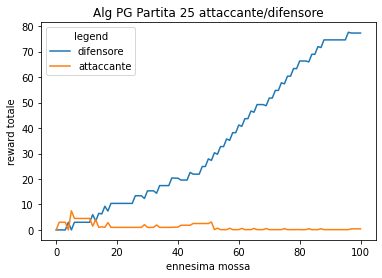

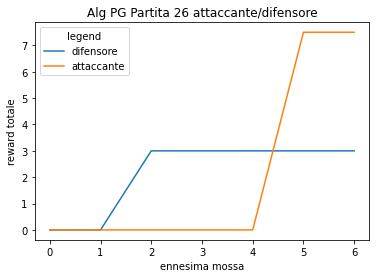

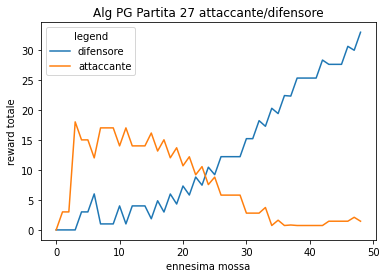

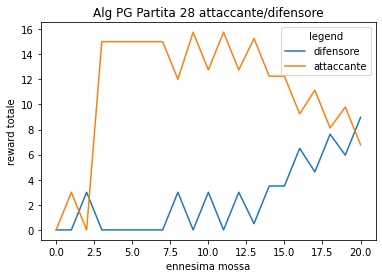

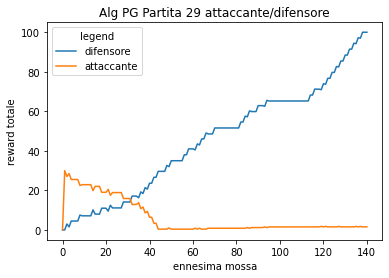

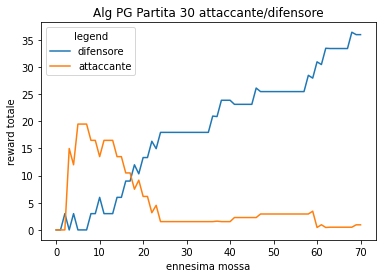

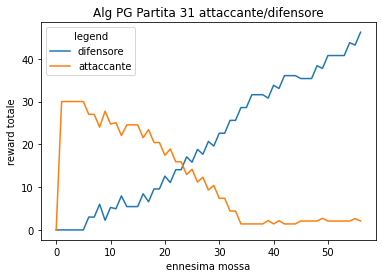

In [92]:

l = {'attaccante': [(1, 0), (2, 30), (3, 27), (4, 27.0), (5, 24.0), (6, 24.0), (7, 24.0), (8, 29.0), (9, 26.0), (10, 29.75), (11, 26.75), (12, 29.75), (13, 26.75), (14, 29.25), (15, 26.25), (16, 28.392857142857142), (17, 28.392857142857142), (1, 0), (2, 0), (3, 0), (4, 15.0), (5, 15.0), (6, 15.0), (7, 12.0), (8, 12.0), (9, 12.0), (10, 15.75), (11, 12.75), (12, 12.75), (13, 9.75), (14, 10.0), (15, 7.0), (16, 9.142857142857142), (17, 6.142857142857142), (18, 8.017857142857142), (19, 5.017857142857142), (20, 6.684523809523809), (21, 3.6845238095238093), (22, 5.184523809523809), (23, 5.184523809523809), (24, 5.184523809523809), (25, 2.1845238095238093), (26, 3.4345238095238093), (27, 0.4345238095238093), (28, 1.588369963369963), (29, 0.4345238095238093), (30, 1.5059523809523807), (31, 0.4345238095238093), (32, 0.4345238095238093), (33, 0.4345238095238093), (34, 0.4345238095238093), (35, 0.4345238095238093), (36, 1.3168767507002799), (37, 0.4345238095238093), (38, 0.5178571428571427), (39, 0.43452380952380937), (1, 0), (2, 30), (3, 27), (4, 27.0), (5, 27.0), (6, 27.0), (7, 27.0), (8, 27.0), (9, 27.0), (10, 27.0), (11, 24.0), (12, 27.0), (13, 27.0), (14, 27.0), (15, 24.0), (16, 26.142857142857142), (17, 23.142857142857142), (18, 25.017857142857142), (19, 22.017857142857142), (20, 23.68452380952381), (21, 20.68452380952381), (22, 20.68452380952381), (23, 20.68452380952381), (24, 20.68452380952381), (25, 20.68452380952381), (26, 20.68452380952381), (27, 17.68452380952381), (28, 18.838369963369964), (29, 18.838369963369964), (30, 18.838369963369964), (31, 18.838369963369964), (32, 18.838369963369964), (33, 18.838369963369964), (34, 18.838369963369964), (35, 18.838369963369964), (36, 18.838369963369964), (37, 18.838369963369964), (38, 18.838369963369964), (39, 18.838369963369964), (40, 18.838369963369964), (41, 18.838369963369964), (42, 18.838369963369964), (43, 18.838369963369964), (44, 18.838369963369964), (45, 15.838369963369964), (46, 16.520188145188147), (47, 13.520188145188147), (48, 13.520188145188147), (49, 13.520188145188147), (50, 13.520188145188147), (51, 13.520188145188147), (52, 13.520188145188147), (53, 13.520188145188147), (54, 13.520188145188147), (55, 13.520188145188147), (56, 13.520188145188147), (57, 13.520188145188147), (58, 13.520188145188147), (59, 13.520188145188147), (60, 13.520188145188147), (61, 13.520188145188147), (62, 13.520188145188147), (63, 13.520188145188147), (64, 13.520188145188147), (65, 10.520188145188147), (66, 10.988938145188147), (67, 10.988938145188147), (68, 10.988938145188147), (69, 7.988938145188147), (70, 8.430114615776382), (71, 8.430114615776382), (72, 8.430114615776382), (73, 8.430114615776382), (74, 8.430114615776382), (75, 5.430114615776382), (76, 5.835520021181788), (77, 5.835520021181788), (78, 5.835520021181788), (79, 2.8355200211817877), (80, 2.8355200211817877), (81, 2.8355200211817877), (82, 3.2105200211817877), (83, 0.2105200211817877), (84, 0.576373679718373), (85, 0.576373679718373), (86, 0.576373679718373), (87, 0.576373679718373), (88, 0.576373679718373), (89, 0.576373679718373), (90, 0.917282770627464), (91, 0.5763736797183732), (1, 0), (2, 30), (3, 27), (4, 27.0), (5, 27.0), (6, 27.0), (7, 24.0), (8, 29.0), (9, 26.0), (10, 26.0), (11, 26.0), (1, 0), (2, 3), (3, 0), (4, 0.0), (5, 0.0), (6, 7.5), (7, 7.5), (1, 0), (2, 3), (3, 0), (4, 1.5), (5, 0.0), (6, 0.0), (7, 0.0), (8, 5.0), (9, 2.0), (10, 2.0), (11, 2.0), (12, 5.0), (13, 2.0), (14, 2.0), (15, 2.0), (16, 4.142857142857142), (17, 1.1428571428571423), (18, 3.0178571428571423), (19, 0.01785714285714235), (20, 0.01785714285714235), (21, 0.01785714285714235), (22, 1.5178571428571423), (23, 0.01785714285714235), (24, 0.01785714285714235), (25, 0.01785714285714235), (26, 0.01785714285714235), (27, 0.01785714285714235), (28, 0.01785714285714235), (29, 0.01785714285714235), (30, 0.01785714285714235), (31, 0.01785714285714235), (32, 1.0178571428571423), (33, 0.01785714285714235), (34, 0.9553571428571423), (35, 0.01785714285714235), (36, 0.9002100840336129), (37, 0.9002100840336129), (38, 0.9002100840336129), (39, 0.9002100840336129), (40, 0.9002100840336129), (41, 0.9002100840336129), (42, 0.9002100840336129), (43, 0.9002100840336129), (44, 0.9002100840336129), (45, 0.9002100840336129), (46, 0.968391902215431), (47, 0.9002100840336129), (48, 1.5523839970770912), (49, 1.5523839970770912), (50, 1.5523839970770912), (51, 1.5523839970770912), (52, 1.5523839970770912), (53, 1.5523839970770912), (54, 1.5523839970770912), (55, 1.5523839970770912), (56, 1.5523839970770912), (57, 1.5523839970770912), (58, 1.5523839970770912), (59, 1.5523839970770912), (60, 1.5523839970770912), (61, 1.5523839970770912), (62, 2.052383997077091), (63, 2.052383997077091), (64, 2.052383997077091), (65, 2.052383997077091), (66, 2.052383997077091), (67, 2.052383997077091), (68, 2.5069294516225455), (69, 2.5069294516225455), (70, 2.5069294516225455), (71, 2.5069294516225455), (72, 2.5069294516225455), (73, 2.5069294516225455), (74, 2.923596118289212), (75, 2.923596118289212), (76, 2.923596118289212), (77, 2.923596118289212), (78, 2.923596118289212), (79, 2.923596118289212), (80, 3.3082115029045966), (81, 0.30821150290459665), (82, 0.30821150290459665), (83, 0.30821150290459665), (84, 0.674065161441182), (85, 0.30821150290459665), (86, 0.6653543600474539), (87, 0.3082115029045967), (88, 0.3082115029045967), (89, 0.3082115029045967), (1, 0), (2, 30), (3, 27), (4, 27.0), (5, 24.0), (6, 31.5), (7, 28.5), (8, 33.5), (9, 30.5), (10, 34.25), (11, 31.25), (12, 31.25), (13, 31.25), (14, 31.25), (15, 28.25), (16, 28.25), (17, 25.25), (18, 25.25), (19, 22.25), (20, 22.25), (21, 22.25), (22, 23.75), (23, 20.75), (24, 20.75), (25, 17.75), (26, 17.75), (27, 17.75), (28, 17.75), (29, 14.75), (30, 14.75), (31, 14.75), (32, 15.75), (33, 12.75), (34, 12.75), (35, 9.75), (36, 9.75), (37, 6.75), (38, 6.833333333333333), (39, 3.833333333333333), (40, 3.833333333333333), (41, 0.833333333333333), (42, 1.583333333333333), (43, 0.833333333333333), (44, 1.5476190476190474), (45, 1.5476190476190474), (46, 1.5476190476190474), (47, 1.5476190476190474), (48, 2.199792960662526), (49, 2.199792960662526), (50, 2.199792960662526), (51, 2.199792960662526), (52, 2.199792960662526), (53, 2.199792960662526), (54, 2.7767160375856026), (55, 2.199792960662526), (56, 2.7553485162180813), (57, 2.7553485162180813), (58, 2.7553485162180813), (59, 2.7553485162180813), (60, 3.272589895528426), (61, 3.272589895528426), (62, 3.272589895528426), (63, 0.27258989552842605), (64, 0.7564608632703615), (65, 0.27258989552842605), (66, 0.27258989552842605), (67, 0.27258989552842605), (68, 0.7271353500738806), (69, 0.2725898955284261), (70, 0.7137663661166613), (71, 0.7137663661166613), (72, 0.7137663661166613), (73, 0.7137663661166613), (74, 0.7137663661166613), (75, 0.7137663661166613), (76, 0.7137663661166613), (77, 0.7137663661166613), (78, 0.7137663661166613), (79, 0.7137663661166613), (80, 1.098381750732046), (81, 0.7137663661166613), (82, 0.7137663661166613), (83, 0.7137663661166613), (84, 0.7137663661166613), (85, 0.7137663661166613), (86, 0.7137663661166613), (87, 0.7137663661166613), (88, 1.0626035754189869), (89, 0.7137663661166613), (90, 1.0546754570257522), (91, 1.0546754570257522), (92, 1.0546754570257522), (93, 1.0546754570257522), (94, 1.3807624135474912), (95, 1.3807624135474912), (96, 1.3807624135474912), (97, 1.3807624135474912), (98, 1.6932624135474912), (99, 1.3807624135474912), (100, 1.3807624135474912), (101, 1.3807624135474912), (102, 1.3807624135474912), (103, 1.3807624135474912), (104, 1.3807624135474912), (105, 1.3807624135474912), (1, 0), (2, 0), (3, 0), (4, 15.0), (5, 12.0), (6, 12.0), (7, 12.0), (8, 12.0), (9, 9.0), (10, 9.0), (11, 9.0), (12, 12.0), (13, 9.0), (14, 11.5), (15, 8.5), (16, 10.642857142857142), (17, 7.642857142857142), (18, 9.517857142857142), (19, 6.517857142857142), (20, 8.184523809523808), (21, 5.184523809523808), (22, 6.684523809523808), (23, 3.6845238095238084), (24, 3.6845238095238084), (25, 0.6845238095238084), (26, 1.9345238095238084), (27, 0.6845238095238084), (28, 1.8383699633699622), (29, 1.8383699633699622), (30, 1.8383699633699622), (31, 1.8383699633699622), (32, 1.8383699633699622), (33, 1.8383699633699622), (34, 2.775869963369962), (35, 1.8383699633699622), (36, 1.8383699633699622), (37, 1.8383699633699622), (38, 1.8383699633699622), (39, 1.8383699633699622), (40, 1.8383699633699622), (41, 1.8383699633699622), (42, 1.8383699633699622), (43, 1.8383699633699622), (44, 1.8383699633699622), (45, 1.8383699633699622), (46, 2.520188145188144), (47, 1.8383699633699622), (48, 1.8383699633699622), (49, 1.8383699633699622), (50, 1.8383699633699622), (51, 1.8383699633699622), (52, 1.8383699633699622), (53, 1.8383699633699622), (54, 1.8383699633699622), (55, 1.8383699633699622), (56, 2.393925518925518), (57, 2.393925518925518), (58, 2.393925518925518), (59, 2.393925518925518), (60, 2.393925518925518), (61, 2.393925518925518), (62, 2.393925518925518), (63, 2.393925518925518), (64, 2.8777964866674535), (65, 2.393925518925518), (66, 2.393925518925518), (67, 2.393925518925518), (68, 2.393925518925518), (69, 2.393925518925518), (70, 2.393925518925518), (71, 2.393925518925518), (72, 2.8224969474969464), (73, 2.8224969474969464), (74, 2.8224969474969464), (75, 2.8224969474969464), (76, 3.2279023529023516), (77, 0.2279023529023516), (78, 0.2279023529023516), (79, 0.2279023529023516), (80, 0.26636389136389005), (81, 0.22790235290235158), (82, 0.22790235290235158), (83, 0.22790235290235158), (84, 0.593756011438937), (85, 0.593756011438937), (86, 0.593756011438937), (87, 0.593756011438937), (88, 0.9425932207412626), (89, 0.9425932207412626), (90, 0.9425932207412626), (91, 0.9425932207412626), (92, 0.9759265540745959), (93, 0.9425932207412626), (94, 1.2686801772630019), (95, 0.9425932207412627), (96, 0.9425932207412627), (97, 0.9425932207412627), (98, 1.2550932207412626), (99, 0.9425932207412626), (100, 0.9425932207412626), (101, 0.9425932207412626), (102, 1.2425932207412627), (103, 0.9425932207412626), (104, 1.2367108678000862), (105, 0.9425932207412626), (106, 0.9425932207412626), (107, 0.9425932207412626), (108, 0.9425932207412626), (109, 0.9425932207412626), (110, 1.2203709985190403), (111, 0.9425932207412625), (112, 0.9425932207412625), (113, 0.9425932207412625), (114, 0.9425932207412625), (115, 0.9425932207412625), (116, 0.9425932207412625), (117, 0.9425932207412625), (118, 1.201213910396435), (119, 0.9425932207412626), (120, 0.9425932207412626), (121, 0.9425932207412626), (122, 0.9675932207412626), (123, 0.9425932207412626), (124, 0.9425932207412626), (125, 0.9425932207412626), (126, 1.1845287046122304), (127, 1.1845287046122304), (128, 1.1845287046122304), (129, 1.1845287046122304), (130, 1.1845287046122304), (131, 1.1845287046122304), (132, 1.1845287046122304), (133, 1.1845287046122304), (134, 1.1845287046122304), (135, 1.1845287046122304), (136, 1.1845287046122304), (137, 1.1845287046122304), (138, 1.405116939906348), (139, 1.405116939906348), (140, 1.405116939906348), (141, 1.405116939906348), (142, 1.405116939906348), (143, 1.405116939906348), (144, 1.405116939906348), (145, 1.405116939906348), (146, 1.405116939906348), (147, 1.405116939906348), (148, 1.405116939906348), (149, 1.405116939906348), (150, 1.6078196426090505), (151, 1.6078196426090505), (152, 1.6078196426090505), (153, 1.6078196426090505), (154, 1.6078196426090505), (155, 1.6078196426090505), (156, 1.8026248374142453), (157, 1.8026248374142453), (158, 1.8026248374142453), (159, 1.8026248374142453), (160, 1.9924982551357644), (161, 1.9924982551357644), (1, 0), (2, 30), (3, 27), (4, 42.0), (5, 42.0), (1, 0), (2, 0), (3, 0), (4, 15.0), (5, 12.0), (6, 19.5), (7, 16.5), (8, 16.5), (9, 13.5), (10, 13.5), (11, 10.5), (12, 10.5), (13, 7.5), (14, 10.0), (15, 7.0), (16, 9.142857142857142), (17, 6.142857142857142), (18, 8.017857142857142), (19, 8.017857142857142), (20, 8.017857142857142), (21, 5.017857142857142), (22, 6.517857142857142), (23, 3.5178571428571423), (24, 4.881493506493506), (25, 4.881493506493506), (26, 4.881493506493506), (27, 1.8814935064935057), (28, 1.8814935064935057), (29, 1.8814935064935057), (30, 1.8814935064935057), (31, 1.8814935064935057), (32, 1.8814935064935057), (33, 1.8814935064935057), (34, 1.8814935064935057), (35, 1.8814935064935057), (36, 1.8814935064935057), (37, 1.8814935064935057), (38, 2.714826839826839), (39, 1.8814935064935057), (40, 1.9604408749145583), (41, 1.9604408749145583), (42, 1.9604408749145583), (43, 1.9604408749145583), (44, 2.6747265892002727), (45, 2.6747265892002727), (46, 2.6747265892002727), (47, 2.6747265892002727), (48, 2.6747265892002727), (49, 2.6747265892002727), (50, 3.2997265892002727), (51, 0.29972658920027273), (52, 0.29972658920027273), (53, 0.29972658920027273), (54, 0.8766496661233496), (55, 0.29972658920027273), (56, 0.8552821447558283), (57, 0.29972658920027273), (58, 0.8354408749145584), (59, 0.8354408749145584), (60, 0.8354408749145584), (61, 0.8354408749145584), (1, 0), (2, 3), (3, 0), (4, 15.0), (5, 12.0), (6, 12.0), (7, 9.0), (8, 9.5), (9, 9.5), (10, 9.5), (11, 9.5), (12, 9.5), (13, 6.5), (14, 6.5), (15, 3.5), (16, 5.642857142857142), (17, 5.642857142857142), (18, 5.642857142857142), (19, 5.642857142857142), (20, 5.642857142857142), (21, 5.642857142857142), (22, 5.642857142857142), (23, 2.6428571428571423), (24, 2.6428571428571423), (25, 2.6428571428571423), (26, 3.8928571428571423), (27, 3.8928571428571423), (28, 3.8928571428571423), (29, 0.8928571428571423), (30, 0.8928571428571423), (31, 0.8928571428571423), (32, 0.8928571428571423), (33, 0.8928571428571423), (34, 0.8928571428571423), (35, 0.8928571428571423), (36, 0.8928571428571423), (37, 0.8928571428571423), (38, 0.8928571428571423), (39, 0.8928571428571423), (40, 1.6823308270676687), (41, 0.8928571428571423), (42, 1.6428571428571423), (43, 0.8928571428571423), (44, 1.6071428571428568), (45, 1.6071428571428568), (46, 1.6071428571428568), (47, 1.6071428571428568), (48, 1.6071428571428568), (49, 1.6071428571428568), (50, 1.6071428571428568), (51, 1.6071428571428568), (52, 2.207142857142857), (53, 2.207142857142857), (54, 2.207142857142857), (55, 2.207142857142857), (56, 2.207142857142857), (57, 2.207142857142857), (58, 2.207142857142857), (59, 2.207142857142857), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 0.0), (6, 7.5), (7, 4.5), (8, 4.5), (9, 1.5), (10, 5.25), (11, 2.25), (12, 2.25), (13, 2.25), (14, 2.25), (15, 2.25), (16, 4.392857142857142), (17, 1.3928571428571423), (18, 3.2678571428571423), (19, 3.2678571428571423), (20, 3.2678571428571423), (21, 0.26785714285714235), (22, 0.26785714285714235), (23, 0.26785714285714235), (24, 1.6314935064935059), (25, 0.26785714285714235), (26, 0.26785714285714235), (27, 0.26785714285714235), (28, 0.26785714285714235), (29, 0.26785714285714235), (30, 1.3392857142857137), (31, 0.26785714285714235), (32, 0.26785714285714235), (33, 0.26785714285714235), (34, 1.2053571428571423), (35, 1.2053571428571423), (36, 1.2053571428571423), (37, 1.2053571428571423), (38, 1.2053571428571423), (39, 1.2053571428571423), (40, 1.9948308270676687), (41, 1.9948308270676687), (42, 1.9948308270676687), (43, 1.9948308270676687), (44, 2.709116541353383), (45, 1.9948308270676685), (46, 2.67664900888585), (47, 2.67664900888585), (48, 2.67664900888585), (49, 2.67664900888585), (50, 2.67664900888585), (51, 2.67664900888585), (52, 3.27664900888585), (53, 0.2766490088858502), (54, 0.2766490088858502), (55, 0.2766490088858502), (56, 0.8322045644414058), (57, 0.2766490088858502), (1, 0), (2, 3), (3, 0), (4, 15.0), (5, 12.0), (6, 12.0), (7, 9.0), (8, 9.0), (9, 9.0), (1, 0), (2, 3), (3, 3), (4, 3.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 5.0), (9, 5.0), (10, 5.0), (11, 2.0), (12, 5.0), (13, 2.0), (14, 4.5), (15, 1.5), (16, 3.642857142857143), (17, 0.6428571428571428), (18, 2.517857142857143), (19, 0.6428571428571428), (20, 0.6428571428571428), (21, 0.6428571428571428), (22, 2.142857142857143), (23, 0.6428571428571428), (24, 0.6428571428571428), (25, 0.6428571428571428), (26, 0.6428571428571428), (27, 0.6428571428571428), (28, 0.6428571428571428), (29, 0.6428571428571428), (30, 0.6428571428571428), (31, 0.6428571428571428), (32, 0.6428571428571428), (33, 0.6428571428571428), (34, 1.5803571428571428), (35, 0.6428571428571428), (36, 1.5252100840336134), (37, 1.5252100840336134), (38, 1.5252100840336134), (39, 1.5252100840336134), (40, 1.5252100840336134), (41, 1.5252100840336134), (42, 1.5252100840336134), (43, 1.5252100840336134), (44, 2.2394957983193278), (45, 1.5252100840336134), (1, 0), (2, 30), (3, 27), (4, 42.0), (5, 39.0), (6, 46.5), (7, 43.5), (8, 43.5), (9, 40.5), (10, 44.25), (11, 41.25), (12, 44.25), (13, 41.25), (14, 43.75), (15, 40.75), (16, 40.75), (17, 37.75), (18, 37.75), (19, 34.75), (20, 36.416666666666664), (21, 33.416666666666664), (22, 33.416666666666664), (23, 30.416666666666664), (24, 30.5530303030303), (25, 27.5530303030303), (26, 28.8030303030303), (27, 25.8030303030303), (28, 26.956876456876454), (29, 23.956876456876454), (30, 23.956876456876454), (31, 20.956876456876454), (32, 21.956876456876454), (33, 18.956876456876454), (34, 19.894376456876454), (35, 16.894376456876454), (36, 17.776729398052925), (37, 14.776729398052925), (38, 15.61006273138626), (39, 12.61006273138626), (40, 13.399536415596785), (41, 10.399536415596785), (42, 11.149536415596785), (43, 8.149536415596785), (44, 8.149536415596785), (45, 5.149536415596785), (46, 5.217718233778603), (47, 2.217718233778603), (48, 2.217718233778603), (49, 2.217718233778603), (50, 2.842718233778603), (51, 2.217718233778603), (52, 2.8177182337786033), (53, 2.217718233778603), (54, 2.217718233778603), (55, 2.217718233778603), (56, 2.7732737893341586), (57, 2.217718233778603), (58, 2.753432519492889), (59, 2.753432519492889), (60, 2.753432519492889), (61, 2.753432519492889), (62, 2.8034325194928886), (63, 2.753432519492889), (64, 2.753432519492889), (65, 2.753432519492889), (66, 3.222182519492889), (67, 3.222182519492889), (68, 3.222182519492889), (69, 0.2221825194928888), (70, 0.2221825194928888), (71, 0.2221825194928888), (72, 0.2221825194928888), (73, 0.2221825194928888), (74, 0.2221825194928888), (75, 0.2221825194928888), (76, 0.2221825194928888), (77, 0.2221825194928888), (78, 0.616919361598152), (79, 0.616919361598152), (80, 0.616919361598152), (81, 0.616919361598152), (82, 0.616919361598152), (83, 0.616919361598152), (84, 0.616919361598152), (85, 0.616919361598152), (86, 0.616919361598152), (87, 0.616919361598152), (88, 0.616919361598152), (89, 0.616919361598152), (90, 0.616919361598152), (91, 0.616919361598152), (92, 0.9502526949314853), (93, 0.6169193615981521), (94, 0.6169193615981521), (95, 0.6169193615981521), (96, 0.9360682977683649), (97, 0.6169193615981521), (98, 0.9294193615981521), (99, 0.9294193615981521), (100, 0.9294193615981521), (101, 0.9294193615981521), (102, 0.9294193615981521), (103, 0.9294193615981521), (104, 0.9294193615981521), (105, 0.9294193615981521), (106, 1.2178809000596904), (107, 0.929419361598152), (108, 1.2124382295226803), (109, 0.9294193615981521), (110, 1.2071971393759298), (111, 0.929419361598152), (112, 0.9566920888708792), (113, 0.9566920888708792), (114, 0.9566920888708792), (115, 0.9566920888708792), (116, 1.2198499836077212), (117, 0.9566920888708792), (118, 1.2153127785260516), (119, 0.9566920888708792), (120, 1.2109293770064724), (121, 1.2109293770064724), (122, 1.2109293770064724), (123, 1.2109293770064724), (124, 1.4568310163507348), (125, 1.2109293770064724), (126, 1.2109293770064724), (127, 1.2109293770064724), (128, 1.4490246151017105), (129, 1.4490246151017105), (130, 1.4490246151017105), (131, 1.4490246151017105), (132, 1.6797938458709414), (133, 1.6797938458709414), (134, 1.6797938458709414), (135, 1.6797938458709414), (136, 1.6797938458709414), (137, 1.6797938458709414), (138, 1.701852669400353), (139, 1.701852669400353), (140, 1.701852669400353), (141, 1.701852669400353), (142, 1.701852669400353), (143, 1.701852669400353), (144, 1.7229794299637333), (145, 1.701852669400353), (146, 1.701852669400353), (147, 1.701852669400353), (148, 1.9073321214551475), (149, 1.9073321214551475), (150, 1.9073321214551475), (151, 1.9073321214551475), (152, 1.9073321214551475), (153, 1.9073321214551475), (154, 2.104700542507779), (155, 1.9073321214551473), (156, 1.9073321214551473), (157, 1.9073321214551473), (158, 2.0996398137628396), (159, 2.0996398137628396), (160, 2.0996398137628396), (161, 2.0996398137628396), (162, 2.0996398137628396), (163, 2.0996398137628396), (164, 2.0996398137628396), (165, 2.0996398137628396), (166, 2.0996398137628396), (167, 2.0996398137628396), (168, 2.0996398137628396), (169, 2.0996398137628396), (1, 0), (2, 3), (3, 3), (4, 18.0), (5, 15.0), (6, 22.5), (7, 19.5), (8, 20.0), (9, 17.0), (10, 17.0), (11, 14.0), (12, 14.0), (13, 11.0), (14, 11.0), (15, 11.0), (16, 11.0), (17, 8.0), (18, 8.0), (19, 5.0), (20, 5.0), (21, 2.0), (22, 3.5), (23, 0.5), (24, 1.8636363636363635), (25, 1.8636363636363635), (26, 1.8636363636363635), (27, 1.8636363636363635), (28, 1.8636363636363635), (29, 1.8636363636363635), (30, 2.935064935064935), (31, 1.8636363636363635), (32, 2.8636363636363633), (33, 2.8636363636363633), (34, 2.8636363636363633), (35, 2.8636363636363633), (36, 3.745989304812834), (37, 3.745989304812834), (38, 3.745989304812834), (39, 3.745989304812834), (40, 3.745989304812834), (41, 0.7459893048128339), (42, 1.4959893048128339), (43, 1.4959893048128339), (44, 1.4959893048128339), (45, 1.4959893048128339), (46, 1.4959893048128339), (47, 1.4959893048128339), (48, 1.4959893048128339), (49, 1.4959893048128339), (50, 1.4959893048128339), (51, 1.4959893048128339), (52, 1.4959893048128339), (53, 1.4959893048128339), (54, 2.072912381735911), (55, 2.072912381735911), (56, 2.072912381735911), (57, 2.072912381735911), (58, 2.072912381735911), (59, 2.072912381735911), (60, 2.5901537610462557), (61, 2.072912381735911), (62, 2.572912381735911), (63, 2.572912381735911), (64, 2.572912381735911), (65, 2.572912381735911), (66, 2.572912381735911), (67, 2.572912381735911), (68, 2.572912381735911), (69, 2.572912381735911), (70, 2.572912381735911), (71, 2.572912381735911), (72, 3.0014838103073394), (73, 0.0014838103073393505), (74, 0.41815047697400604), (75, 0.41815047697400604), (76, 0.41815047697400604), (77, 0.41815047697400604), (78, 0.41815047697400604), (79, 0.41815047697400604), (80, 0.8027658615893907), (81, 0.41815047697400604), (82, 0.7931504769740061), (83, 0.7931504769740061), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 3.75), (11, 0.75), (12, 0.75), (13, 0.75), (14, 3.25), (15, 0.25), (16, 0.25), (17, 0.25), (18, 0.25), (19, 0.25), (20, 0.25), (21, 0.25), (22, 0.25), (23, 0.25), (24, 1.6136363636363635), (25, 1.6136363636363635), (26, 1.6136363636363635), (27, 1.6136363636363635), (28, 1.6136363636363635), (29, 1.6136363636363635), (30, 2.685064935064935), (31, 2.685064935064935), (32, 2.685064935064935), (33, 2.685064935064935), (34, 3.622564935064935), (35, 0.6225649350649349), (36, 1.5049178762414055), (37, 1.5049178762414055), (38, 1.5049178762414055), (39, 1.5049178762414055), (40, 1.5049178762414055), (41, 1.5049178762414055), (42, 2.2549178762414055), (43, 1.5049178762414055), (44, 1.5049178762414055), (45, 1.5049178762414055), (46, 1.5730996944232236), (47, 1.5049178762414055), (48, 2.157091789284884), (49, 1.5049178762414057), (50, 1.5049178762414057), (51, 1.5049178762414057), (52, 2.1049178762414056), (53, 2.1049178762414056), (54, 2.1049178762414056), (55, 2.1049178762414056), (56, 2.1049178762414056), (57, 2.1049178762414056), (58, 2.640632161955691), (59, 2.1049178762414056), (60, 2.1049178762414056), (61, 2.1049178762414056), (62, 2.6049178762414056), (63, 2.6049178762414056), (1, 0), (2, 0), (3, 0), (4, 1.5), (5, 1.5), (6, 1.5), (7, 1.5), (8, 1.5), (9, 1.5), (10, 1.5), (11, 1.5), (12, 4.5), (13, 4.5), (14, 4.5), (15, 1.5), (16, 3.642857142857143), (17, 3.642857142857143), (18, 3.642857142857143), (19, 0.6428571428571428), (20, 0.6428571428571428), (21, 0.6428571428571428), (22, 2.142857142857143), (23, 2.142857142857143), (1, 0), (2, 30), (3, 30), (4, 30.0), (5, 27.0), (6, 27.0), (7, 24.0), (8, 24.0), (9, 24.0), (10, 24.0), (11, 21.0), (12, 24.0), (13, 21.0), (14, 21.0), (15, 18.0), (16, 20.142857142857142), (17, 20.142857142857142), (18, 20.142857142857142), (19, 17.142857142857142), (20, 17.142857142857142), (21, 17.142857142857142), (22, 17.142857142857142), (23, 14.142857142857142), (24, 15.506493506493506), (25, 12.506493506493506), (26, 13.756493506493506), (27, 13.756493506493506), (28, 13.756493506493506), (29, 10.756493506493506), (30, 11.827922077922077), (31, 8.827922077922077), (32, 8.827922077922077), (33, 5.827922077922077), (34, 6.765422077922077), (35, 3.765422077922077), (36, 3.853657372039724), (37, 3.853657372039724), (38, 3.853657372039724), (39, 0.853657372039724), (40, 1.6431310562502504), (41, 0.853657372039724), (42, 0.853657372039724), (43, 0.853657372039724), (44, 1.5679430863254384), (45, 0.8536573720397241), (46, 1.535475553857906), (47, 0.8536573720397241), (48, 1.5058312850832025), (49, 0.8536573720397242), (50, 0.9161573720397242), (51, 0.9161573720397242), (52, 0.9161573720397242), (53, 0.9161573720397242), (54, 0.973849679732032), (55, 0.9161573720397242), (56, 1.4717129275952798), (57, 0.9161573720397242), (58, 0.9161573720397242), (59, 0.9161573720397242), (60, 0.9161573720397242), (61, 0.9161573720397242), (62, 1.4161573720397242), (63, 0.9161573720397242), (64, 1.4000283397816597), (65, 0.9161573720397242), (66, 0.9161573720397242), (67, 0.9161573720397242), (68, 1.3707028265851788), (69, 1.3707028265851788), (70, 1.3707028265851788), (71, 1.3707028265851788), (72, 1.7992742551566074), (73, 1.7992742551566074), (74, 1.7992742551566074), (75, 1.7992742551566074), (76, 1.7992742551566074), (77, 1.7992742551566074), (78, 1.7992742551566074), (79, 1.7992742551566074), (80, 1.7992742551566074), (81, 1.7992742551566074), (82, 1.7992742551566074), (83, 1.7992742551566074), (84, 2.1651279136931927), (85, 1.7992742551566074), (86, 2.1564171122994646), (87, 1.7992742551566074), (88, 2.148111464458933), (89, 1.7992742551566077), (1, 0), (2, 0), (3, 0), (4, 15.0), (5, 12.0), (6, 12.0), (7, 9.0), (8, 14.0), (9, 11.0), (10, 14.75), (11, 11.75), (12, 11.75), (13, 11.75), (14, 11.75), (15, 11.75), (16, 11.75), (17, 11.75), (18, 11.75), (19, 8.75), (20, 8.75), (21, 5.75), (22, 7.25), (23, 4.25), (24, 5.613636363636363), (25, 2.6136363636363633), (26, 3.8636363636363633), (27, 3.8636363636363633), (28, 3.8636363636363633), (29, 3.8636363636363633), (30, 3.8636363636363633), (31, 0.8636363636363633), (32, 1.8636363636363633), (33, 0.8636363636363633), (34, 1.8011363636363633), (35, 1.8011363636363633), (1, 0), (2, 30), (3, 27), (4, 42.0), (5, 39.0), (6, 46.5), (7, 43.5), (8, 48.5), (9, 48.5), (10, 48.5), (11, 45.5), (12, 45.5), (13, 45.5), (14, 45.5), (15, 42.5), (16, 42.5), (17, 39.5), (18, 41.375), (19, 41.375), (20, 41.375), (21, 38.375), (22, 39.875), (23, 36.875), (24, 38.23863636363637), (25, 35.23863636363637), (26, 36.48863636363637), (27, 33.48863636363637), (28, 33.48863636363637), (29, 30.488636363636367), (30, 31.56006493506494), (31, 28.56006493506494), (32, 28.56006493506494), (33, 28.56006493506494), (34, 28.56006493506494), (35, 28.56006493506494), (36, 29.44241787624141), (37, 29.44241787624141), (38, 29.44241787624141), (39, 29.44241787624141), (40, 29.44241787624141), (41, 26.44241787624141), (42, 26.44241787624141), (43, 23.44241787624141), (44, 23.44241787624141), (45, 20.44241787624141), (46, 20.44241787624141), (47, 17.44241787624141), (48, 17.44241787624141), (49, 14.44241787624141), (50, 15.06741787624141), (51, 12.06741787624141), (52, 12.06741787624141), (53, 9.06741787624141), (54, 9.12511018393372), (55, 9.12511018393372), (56, 9.12511018393372), (57, 6.125110183933719), (58, 6.178681612505148), (59, 6.178681612505148), (60, 6.178681612505148), (61, 3.178681612505148), (62, 3.678681612505148), (63, 3.678681612505148), (64, 3.678681612505148), (65, 0.678681612505148), (66, 1.147431612505148), (67, 1.147431612505148), (68, 1.147431612505148), (69, 1.147431612505148), (70, 1.147431612505148), (71, 1.147431612505148), (72, 1.5760030410765766), (73, 1.147431612505148), (74, 1.5640982791718148), (75, 1.5640982791718148), (76, 1.5640982791718148), (77, 1.5640982791718148), (78, 1.9588351212770778), (79, 1.9588351212770778), (80, 1.9588351212770778), (81, 1.9588351212770778), (82, 1.9588351212770778), (83, 1.9588351212770778), (84, 2.324688779813663), (85, 2.324688779813663), (86, 2.324688779813663), (87, 2.324688779813663), (88, 2.324688779813663), (89, 2.324688779813663), (90, 2.324688779813663), (91, 2.324688779813663), (92, 2.6580221131469965), (93, 2.6580221131469965), (94, 2.6580221131469965), (95, 2.6580221131469965), (96, 2.977171049317209), (97, 2.977171049317209), (98, 2.977171049317209), (99, 2.977171049317209), (100, 2.977171049317209), (101, 2.977171049317209), (102, 3.277171049317209), (103, 0.27717104931720904), (1, 0), (2, 0), (3, 0), (4, 15.0), (5, 12.0), (6, 19.5), (7, 19.5), (8, 19.5), (9, 16.5), (10, 20.25), (11, 17.25), (12, 17.25), (13, 14.25), (1, 0), (2, 0), (3, 0), (4, 15.0), (5, 12.0), (6, 12.0), (7, 9.0), (8, 9.0), (9, 6.0), (10, 9.75), (11, 6.75), (12, 6.75), (13, 3.75), (14, 3.75), (15, 3.75), (16, 3.75), (17, 0.75), (18, 2.625), (19, 0.75), (20, 2.416666666666667), (21, 2.416666666666667), (22, 2.416666666666667), (23, 2.416666666666667), (24, 2.416666666666667), (25, 2.416666666666667), (26, 2.416666666666667), (27, 2.416666666666667), (28, 2.416666666666667), (29, 2.416666666666667), (30, 3.488095238095238), (31, 0.48809523809523814), (32, 0.5880952380952381), (33, 0.48809523809523814), (34, 0.5818452380952381), (35, 0.5818452380952381), (36, 0.6700805322128852), (37, 0.5818452380952381), (38, 0.5818452380952381), (39, 0.5818452380952381), (40, 0.5818452380952381), (41, 0.5818452380952381), (42, 1.3318452380952381), (43, 0.5818452380952381), (44, 0.6532738095238095), (45, 0.5818452380952381), (46, 1.2636634199134198), (47, 0.581845238095238), (48, 0.581845238095238), (49, 0.581845238095238), (50, 0.581845238095238), (51, 0.581845238095238), (52, 0.581845238095238), (53, 0.581845238095238), (54, 1.1587683150183148), (55, 0.5818452380952379), (56, 1.1374007936507935), (57, 0.5818452380952379), (1, 0), (2, 30), (3, 27), (4, 42.0), (5, 39.0), (6, 39.0), (7, 36.0), (8, 41.0), (9, 41.0), (10, 41.0), (11, 38.0), (12, 38.0), (13, 35.0), (14, 37.5), (15, 34.5), (16, 34.5), (17, 31.5), (18, 31.5), (19, 28.5), (20, 28.5), (21, 25.5), (22, 25.5), (23, 25.5), (24, 26.863636363636363), (25, 23.863636363636363), (26, 23.863636363636363), (27, 20.863636363636363), (28, 22.017482517482517), (29, 19.017482517482517), (30, 19.017482517482517), (31, 16.017482517482517), (32, 16.017482517482517), (33, 13.017482517482517), (34, 13.954982517482517), (35, 10.954982517482517), (36, 10.954982517482517), (37, 7.954982517482517), (38, 8.03831585081585), (39, 5.0383158508158505), (40, 5.827789535026377), (41, 2.827789535026377), (42, 2.9027895350263773), (43, 2.827789535026377), (44, 3.5420752493120915), (45, 3.5420752493120915), (46, 3.5420752493120915), (47, 3.5420752493120915), (1, 0), (2, 3), (3, 3), (4, 3.0), (5, 0.0), (6, 7.5), (7, 4.5), (8, 4.5), (9, 4.5), (10, 4.5), (11, 4.5), (12, 4.5), (13, 1.5), (14, 4.0), (15, 1.0), (16, 1.2142857142857142), (17, 0.9999999999999999), (18, 2.875), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 1.0), (25, 1.0), (26, 1.0), (27, 1.0), (28, 1.0), (29, 1.0), (30, 2.071428571428571), (31, 0.9999999999999998), (32, 0.9999999999999998), (33, 0.9999999999999998), (34, 1.9374999999999998), (35, 0.9999999999999998), (36, 0.9999999999999998), (37, 0.9999999999999998), (38, 0.9999999999999998), (39, 0.9999999999999998), (40, 1.0789473684210524), (41, 1.0789473684210524), (42, 1.8289473684210524), (43, 1.8289473684210524), (44, 1.8289473684210524), (45, 1.8289473684210524), (46, 2.5107655502392343), (47, 2.5107655502392343), (48, 2.5107655502392343), (49, 2.5107655502392343), (50, 2.5107655502392343), (51, 2.5107655502392343), (52, 3.1107655502392344), (53, 0.1107655502392344), (54, 0.6876886271623113), (55, 0.1107655502392344), (56, 0.1107655502392344), (57, 0.1107655502392344), (58, 0.6464798359535201), (59, 0.1107655502392344), (60, 0.1107655502392344), (61, 0.1107655502392344), (62, 0.6107655502392344), (63, 0.1107655502392344), (64, 0.1107655502392344), (65, 0.1107655502392344), (66, 0.5795155502392344), (67, 0.1107655502392344), (68, 0.1107655502392344), (69, 0.1107655502392344), (70, 0.5519420208274697), (71, 0.1107655502392344), (72, 0.1107655502392344), (73, 0.1107655502392344), (74, 0.1107655502392344), (75, 0.1107655502392344), (76, 0.5161709556446399), (77, 0.11076555023923446), (78, 0.11076555023923446), (79, 0.11076555023923446), (80, 0.14922708870077292), (81, 0.11076555023923446), (82, 0.11076555023923446), (83, 0.11076555023923446), (84, 0.4766192087758198), (85, 0.11076555023923446), (86, 0.11076555023923446), (87, 0.11076555023923446), (88, 0.45960275954156005), (89, 0.11076555023923446), (90, 0.11076555023923446), (91, 0.11076555023923446), (92, 0.11076555023923446), (93, 0.11076555023923446), (94, 0.11076555023923446), (95, 0.11076555023923446), (96, 0.11076555023923446), (97, 0.11076555023923446), (98, 0.42326555023923446), (99, 0.42326555023923446), (100, 0.42326555023923446), (101, 0.42326555023923446), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 0.0), (6, 7.5), (7, 7.5), (1, 0), (2, 3), (3, 3), (4, 18.0), (5, 15.0), (6, 15.0), (7, 12.0), (8, 17.0), (9, 17.0), (10, 17.0), (11, 14.0), (12, 17.0), (13, 14.0), (14, 14.0), (15, 14.0), (16, 16.142857142857142), (17, 13.142857142857142), (18, 15.017857142857142), (19, 12.017857142857142), (20, 13.684523809523808), (21, 10.684523809523808), (22, 12.184523809523808), (23, 9.184523809523808), (24, 10.548160173160172), (25, 7.548160173160172), (26, 8.798160173160172), (27, 5.798160173160172), (28, 5.798160173160172), (29, 5.798160173160172), (30, 5.798160173160172), (31, 2.7981601731601717), (32, 2.7981601731601717), (33, 2.7981601731601717), (34, 3.7356601731601717), (35, 0.7356601731601717), (36, 1.6180131143366423), (37, 0.7356601731601717), (38, 0.8189935064935051), (39, 0.7356601731601717), (40, 0.7356601731601717), (41, 0.7356601731601717), (42, 0.7356601731601717), (43, 0.7356601731601717), (44, 1.4499458874458862), (45, 1.4499458874458862), (46, 1.4499458874458862), (47, 1.4499458874458862), (48, 2.1021198004893646), (49, 1.4499458874458864), (1, 0), (2, 3), (3, 0), (4, 15.0), (5, 15.0), (6, 15.0), (7, 15.0), (8, 15.0), (9, 12.0), (10, 15.75), (11, 12.75), (12, 15.75), (13, 12.75), (14, 15.25), (15, 12.25), (16, 12.25), (17, 9.25), (18, 11.125), (19, 8.125), (20, 9.791666666666666), (21, 6.791666666666666), (1, 0), (2, 30), (3, 27), (4, 28.5), (5, 25.5), (6, 25.5), (7, 25.5), (8, 25.5), (9, 22.5), (10, 22.875), (11, 22.875), (12, 22.875), (13, 22.875), (14, 22.875), (15, 19.875), (16, 22.017857142857142), (17, 22.017857142857142), (18, 22.017857142857142), (19, 19.017857142857142), (20, 19.017857142857142), (21, 19.017857142857142), (22, 20.517857142857142), (23, 17.517857142857142), (24, 18.881493506493506), (25, 18.881493506493506), (26, 18.881493506493506), (27, 18.881493506493506), (28, 18.881493506493506), (29, 15.881493506493506), (30, 15.881493506493506), (31, 15.881493506493506), (32, 15.881493506493506), (33, 12.881493506493506), (34, 12.881493506493506), (35, 12.881493506493506), (36, 13.763846447669977), (37, 10.763846447669977), (38, 11.59717978100331), (39, 8.59717978100331), (40, 9.386653465213836), (41, 6.386653465213836), (42, 6.386653465213836), (43, 3.3866534652138363), (44, 3.3866534652138363), (45, 0.38665346521383626), (46, 0.38665346521383626), (47, 0.38665346521383626), (48, 0.38665346521383626), (49, 0.38665346521383626), (50, 1.0116534652138363), (51, 0.38665346521383626), (52, 0.38665346521383626), (53, 0.38665346521383626), (54, 0.38665346521383626), (55, 0.38665346521383626), (56, 0.38665346521383626), (57, 0.38665346521383626), (58, 0.38665346521383626), (59, 0.38665346521383626), (60, 0.38665346521383626), (61, 0.38665346521383626), (62, 0.8866534652138363), (63, 0.38665346521383626), (64, 0.8705244329557718), (65, 0.38665346521383626), (66, 0.38665346521383626), (67, 0.38665346521383626), (68, 0.8411989197592908), (69, 0.8411989197592908), (70, 0.8411989197592908), (71, 0.8411989197592908), (72, 0.8411989197592908), (73, 0.8411989197592908), (74, 0.8411989197592908), (75, 0.8411989197592908), (76, 0.8411989197592908), (77, 0.8411989197592908), (78, 0.8411989197592908), (79, 0.8411989197592908), (80, 0.8411989197592908), (81, 0.8411989197592908), (82, 0.8411989197592908), (83, 0.8411989197592908), (84, 0.8411989197592908), (85, 0.8411989197592908), (86, 1.198341776902148), (87, 0.8411989197592908), (88, 1.1900361290616164), (89, 1.1900361290616164), (90, 1.1900361290616164), (91, 1.1900361290616164), (92, 1.1900361290616164), (93, 1.1900361290616164), (94, 1.5161230855833554), (95, 1.1900361290616162), (96, 1.5091850652318288), (97, 1.5091850652318288), (98, 1.5091850652318288), (99, 1.5091850652318288), (100, 1.5091850652318288), (101, 1.5091850652318288), (102, 1.5091850652318288), (103, 1.5091850652318288), (104, 1.5091850652318288), (105, 1.5091850652318288), (106, 1.5091850652318288), (107, 1.5091850652318288), (108, 1.5091850652318288), (109, 1.5091850652318288), (110, 1.5091850652318288), (111, 1.5091850652318288), (112, 1.5091850652318288), (113, 1.5091850652318288), (114, 1.5091850652318288), (115, 1.5091850652318288), (116, 1.5091850652318288), (117, 1.5091850652318288), (118, 1.5350471341973462), (119, 1.5350471341973462), (120, 1.7892844223329394), (121, 1.5350471341973462), (122, 1.7850471341973462), (123, 1.5350471341973462), (124, 1.5350471341973462), (125, 1.5350471341973462), (126, 1.559240682584443), (127, 1.5350471341973462), (128, 1.7731423722925843), (129, 1.5350471341973462), (130, 1.5350471341973462), (131, 1.5350471341973462), (132, 1.5350471341973462), (133, 1.5350471341973462), (134, 1.5350471341973462), (135, 1.5350471341973462), (136, 1.7589277312122715), (137, 1.5350471341973462), (138, 1.755635369491464), (139, 1.5350471341973462), (140, 1.5350471341973462), (141, 1.5350471341973462), (1, 0), (2, 0), (3, 0), (4, 15.0), (5, 12.0), (6, 19.5), (7, 19.5), (8, 19.5), (9, 16.5), (10, 16.5), (11, 13.5), (12, 16.5), (13, 16.5), (14, 16.5), (15, 13.5), (16, 13.5), (17, 10.5), (18, 10.5), (19, 7.5), (20, 9.166666666666666), (21, 6.166666666666666), (22, 6.166666666666666), (23, 3.166666666666666), (24, 4.530303030303029), (25, 1.5303030303030294), (26, 1.5303030303030294), (27, 1.5303030303030294), (28, 1.5303030303030294), (29, 1.5303030303030294), (30, 1.5303030303030294), (31, 1.5303030303030294), (32, 1.5303030303030294), (33, 1.5303030303030294), (34, 1.5303030303030294), (35, 1.5303030303030294), (36, 1.5303030303030294), (37, 1.5303030303030294), (38, 1.6136363636363626), (39, 1.5303030303030294), (40, 1.5303030303030294), (41, 1.5303030303030294), (42, 2.2803030303030294), (43, 2.2803030303030294), (44, 2.2803030303030294), (45, 2.2803030303030294), (46, 2.2803030303030294), (47, 2.2803030303030294), (48, 2.932476943346508), (49, 2.932476943346508), (50, 2.932476943346508), (51, 2.932476943346508), (52, 2.932476943346508), (53, 2.932476943346508), (54, 2.932476943346508), (55, 2.932476943346508), (56, 2.932476943346508), (57, 2.932476943346508), (58, 2.932476943346508), (59, 2.932476943346508), (60, 3.4497183226568526), (61, 0.44971832265685263), (62, 0.9497183226568526), (63, 0.44971832265685263), (64, 0.4981054194310462), (65, 0.4981054194310462), (66, 0.4981054194310462), (67, 0.4981054194310462), (68, 0.4981054194310462), (69, 0.4981054194310462), (70, 0.9392818900192814), (71, 0.9392818900192814), (1, 0), (2, 30), (3, 30), (4, 30.0), (5, 30.0), (6, 30.0), (7, 27.0), (8, 27.0), (9, 24.0), (10, 27.75), (11, 24.75), (12, 25.05), (13, 22.05), (14, 24.55), (15, 24.55), (16, 24.55), (17, 21.55), (18, 23.425), (19, 20.425), (20, 20.425), (21, 17.425), (22, 18.925), (23, 15.925), (24, 15.925), (25, 12.925), (26, 14.175), (27, 11.175), (28, 12.328846153846154), (29, 9.328846153846154), (30, 10.400274725274725), (31, 7.400274725274725), (32, 7.400274725274725), (33, 4.400274725274725), (34, 4.400274725274725), (35, 1.4002747252747252), (36, 1.4002747252747252), (37, 1.4002747252747252), (38, 1.4002747252747252), (39, 1.4002747252747252), (40, 2.1897484094852517), (41, 1.4002747252747254), (42, 2.150274725274725), (43, 1.4002747252747252), (44, 1.4002747252747252), (45, 1.4002747252747252), (46, 2.082092907092907), (47, 2.082092907092907), (48, 2.082092907092907), (49, 2.082092907092907), (50, 2.707092907092907), (51, 2.082092907092907), (52, 2.082092907092907), (53, 2.082092907092907), (54, 2.082092907092907), (55, 2.082092907092907), (56, 2.637648462648462), (57, 2.082092907092907), (1, 0), (2, 30), (3, 30), (4, 30.0), (5, 27.0), (6, 34.5), (7, 31.5), (8, 36.5), (9, 36.5), (10, 36.5), (11, 36.5), (12, 36.5), (13, 33.5), (14, 33.5), (15, 30.5), (16, 30.714285714285715), (17, 30.714285714285715), (18, 30.714285714285715), (19, 27.714285714285715), (20, 27.714285714285715), (21, 27.714285714285715), (22, 27.714285714285715), (23, 27.714285714285715), (24, 27.714285714285715), (25, 27.714285714285715), (26, 27.714285714285715), (27, 24.714285714285715), (28, 24.714285714285715), (29, 24.714285714285715), (30, 24.714285714285715), (31, 21.714285714285715), (32, 22.714285714285715), (33, 22.714285714285715), (34, 22.714285714285715), (35, 22.714285714285715), (36, 22.714285714285715), (37, 22.714285714285715)], 'difensore': [(1, 0), (2, 0), (3, 3), (4, 3.0), (5, 6.0), (6, 6.0), (7, 6.0), (8, 1.0), (9, 4.0), (10, 0.25), (11, 3.25), (12, 0.25), (13, 3.25), (14, 0.75), (15, 3.75), (16, 1.6071428571428572), (17, 1.6071428571428572), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0.0), (7, 3.0), (8, 3.0), (9, 3.0), (10, 3.0), (11, 6.0), (12, 6.0), (13, 9.0), (14, 8.75), (15, 11.75), (16, 9.607142857142858), (17, 12.607142857142858), (18, 10.732142857142858), (19, 13.732142857142858), (20, 12.065476190476192), (21, 15.065476190476192), (22, 13.565476190476192), (23, 13.565476190476192), (24, 13.565476190476192), (25, 16.56547619047619), (26, 15.31547619047619), (27, 18.31547619047619), (28, 17.161630036630036), (29, 20.161630036630036), (30, 19.090201465201464), (31, 22.090201465201464), (32, 22.090201465201464), (33, 25.090201465201464), (34, 25.090201465201464), (35, 28.090201465201464), (36, 27.207848524024993), (37, 30.207848524024993), (38, 30.12451519069166), (39, 33.12451519069166), (1, 0), (2, 0), (3, 3), (4, 3.0), (5, 3.0), (6, 3.0), (7, 3.0), (8, 3.0), (9, 3.0), (10, 3.0), (11, 6.0), (12, 3.0), (13, 3.0), (14, 3.0), (15, 6.0), (16, 3.857142857142857), (17, 6.857142857142858), (18, 4.982142857142858), (19, 7.982142857142858), (20, 6.315476190476191), (21, 9.31547619047619), (22, 9.31547619047619), (23, 9.31547619047619), (24, 9.31547619047619), (25, 9.31547619047619), (26, 9.31547619047619), (27, 12.31547619047619), (28, 11.161630036630036), (29, 11.161630036630036), (30, 11.161630036630036), (31, 11.161630036630036), (32, 11.161630036630036), (33, 11.161630036630036), (34, 11.161630036630036), (35, 11.161630036630036), (36, 11.161630036630036), (37, 11.161630036630036), (38, 11.161630036630036), (39, 11.161630036630036), (40, 11.161630036630036), (41, 11.161630036630036), (42, 11.161630036630036), (43, 11.161630036630036), (44, 11.161630036630036), (45, 14.161630036630036), (46, 13.479811854811855), (47, 16.479811854811857), (48, 16.479811854811857), (49, 16.479811854811857), (50, 16.479811854811857), (51, 16.479811854811857), (52, 16.479811854811857), (53, 16.479811854811857), (54, 16.479811854811857), (55, 16.479811854811857), (56, 16.479811854811857), (57, 16.479811854811857), (58, 16.479811854811857), (59, 16.479811854811857), (60, 16.479811854811857), (61, 16.479811854811857), (62, 16.479811854811857), (63, 16.479811854811857), (64, 16.479811854811857), (65, 19.479811854811857), (66, 19.011061854811857), (67, 19.011061854811857), (68, 19.011061854811857), (69, 22.011061854811857), (70, 21.56988538422362), (71, 21.56988538422362), (72, 21.56988538422362), (73, 21.56988538422362), (74, 21.56988538422362), (75, 24.56988538422362), (76, 24.164479978818214), (77, 24.164479978818214), (78, 24.164479978818214), (79, 27.164479978818214), (80, 27.164479978818214), (81, 30.164479978818214), (82, 29.789479978818214), (83, 32.789479978818214), (84, 32.42362632028163), (85, 32.42362632028163), (86, 32.42362632028163), (87, 35.42362632028163), (88, 35.42362632028163), (89, 35.42362632028163), (90, 35.082717229372534), (91, 38.082717229372534), (1, 0), (2, 0), (3, 3), (4, 3.0), (5, 3.0), (6, 3.0), (7, 6.0), (8, 1.0), (9, 4.0), (10, 4.0), (11, 4.0), (1, 0), (2, 0), (3, 3), (4, 3.0), (5, 6.0), (6, 3.0), (7, 3.0), (1, 0), (2, 0), (3, 3), (4, 1.5), (5, 4.5), (6, 4.5), (7, 4.5), (8, 4.5), (9, 7.5), (10, 7.5), (11, 7.5), (12, 4.5), (13, 7.5), (14, 7.5), (15, 7.5), (16, 5.357142857142858), (17, 8.357142857142858), (18, 6.482142857142858), (19, 9.482142857142858), (20, 9.482142857142858), (21, 12.482142857142858), (22, 10.982142857142858), (23, 13.982142857142858), (24, 13.982142857142858), (25, 16.982142857142858), (26, 16.982142857142858), (27, 19.982142857142858), (28, 19.982142857142858), (29, 22.982142857142858), (30, 22.982142857142858), (31, 22.982142857142858), (32, 21.982142857142858), (33, 24.982142857142858), (34, 24.044642857142858), (35, 27.044642857142858), (36, 26.162289915966387), (37, 26.162289915966387), (38, 26.162289915966387), (39, 29.162289915966387), (40, 29.162289915966387), (41, 29.162289915966387), (42, 29.162289915966387), (43, 32.16228991596638), (44, 32.16228991596638), (45, 35.16228991596638), (46, 35.09410809778456), (47, 38.09410809778456), (48, 37.441934184741086), (49, 37.441934184741086), (50, 37.441934184741086), (51, 40.441934184741086), (52, 40.441934184741086), (53, 40.441934184741086), (54, 40.441934184741086), (55, 43.441934184741086), (56, 43.441934184741086), (57, 43.441934184741086), (58, 43.441934184741086), (59, 46.441934184741086), (60, 46.441934184741086), (61, 46.441934184741086), (62, 45.941934184741086), (63, 45.941934184741086), (64, 45.941934184741086), (65, 45.941934184741086), (66, 45.941934184741086), (67, 48.941934184741086), (68, 48.48738873019563), (69, 48.48738873019563), (70, 48.48738873019563), (71, 48.48738873019563), (72, 48.48738873019563), (73, 51.48738873019563), (74, 51.07072206352897), (75, 51.07072206352897), (76, 51.07072206352897), (77, 51.07072206352897), (78, 51.07072206352897), (79, 54.07072206352897), (80, 53.68610667891358), (81, 56.68610667891358), (82, 56.68610667891358), (83, 56.68610667891358), (84, 56.320253020376995), (85, 59.320253020376995), (86, 58.96311016323414), (87, 61.96311016323414), (88, 61.96311016323414), (89, 64.96311016323415), (1, 0), (2, 0), (3, 3), (4, 3.0), (5, 6.0), (6, 3.0), (7, 6.0), (8, 1.0), (9, 4.0), (10, 0.25), (11, 3.25), (12, 3.25), (13, 3.25), (14, 3.25), (15, 6.25), (16, 6.25), (17, 9.25), (18, 9.25), (19, 12.25), (20, 12.25), (21, 12.25), (22, 10.75), (23, 13.75), (24, 13.75), (25, 16.75), (26, 16.75), (27, 16.75), (28, 16.75), (29, 19.75), (30, 19.75), (31, 19.75), (32, 18.75), (33, 21.75), (34, 21.75), (35, 24.75), (36, 24.75), (37, 27.75), (38, 27.666666666666668), (39, 30.666666666666668), (40, 30.666666666666668), (41, 33.66666666666667), (42, 32.91666666666667), (43, 35.91666666666667), (44, 35.202380952380956), (45, 35.202380952380956), (46, 35.202380952380956), (47, 38.202380952380956), (48, 37.55020703933748), (49, 37.55020703933748), (50, 37.55020703933748), (51, 40.55020703933748), (52, 40.55020703933748), (53, 43.55020703933748), (54, 42.9732839624144), (55, 45.9732839624144), (56, 45.41772840685884), (57, 45.41772840685884), (58, 45.41772840685884), (59, 48.41772840685884), (60, 47.9004870275485), (61, 47.9004870275485), (62, 47.9004870275485), (63, 50.9004870275485), (64, 50.416616059806564), (65, 53.416616059806564), (66, 53.416616059806564), (67, 56.416616059806564), (68, 55.96207060526111), (69, 58.96207060526111), (70, 58.52089413467288), (71, 58.52089413467288), (72, 58.52089413467288), (73, 61.52089413467288), (74, 61.52089413467288), (75, 61.52089413467288), (76, 61.52089413467288), (77, 64.52089413467289), (78, 64.52089413467289), (79, 64.52089413467289), (80, 64.1362787500575), (81, 67.1362787500575), (82, 67.1362787500575), (83, 70.1362787500575), (84, 70.1362787500575), (85, 73.1362787500575), (86, 73.1362787500575), (87, 76.1362787500575), (88, 75.78744154075517), (89, 78.78744154075517), (90, 78.44653244984607), (91, 78.44653244984607), (92, 78.44653244984607), (93, 81.44653244984607), (94, 81.12044549332434), (95, 81.12044549332434), (96, 81.12044549332434), (97, 84.12044549332434), (98, 83.80794549332434), (99, 86.80794549332434), (100, 86.80794549332434), (101, 89.80794549332434), (102, 89.80794549332434), (103, 92.80794549332434), (104, 92.80794549332434), (105, 95.80794549332434), (1, 0), (2, 0), (3, 0), (4, 0), (5, 3), (6, 3.0), (7, 3.0), (8, 3.0), (9, 6.0), (10, 6.0), (11, 6.0), (12, 3.0), (13, 6.0), (14, 3.5), (15, 6.5), (16, 4.357142857142858), (17, 7.357142857142858), (18, 5.482142857142858), (19, 8.482142857142858), (20, 6.815476190476191), (21, 9.81547619047619), (22, 8.31547619047619), (23, 11.31547619047619), (24, 11.31547619047619), (25, 14.31547619047619), (26, 13.06547619047619), (27, 16.06547619047619), (28, 14.911630036630036), (29, 14.911630036630036), (30, 14.911630036630036), (31, 17.911630036630036), (32, 17.911630036630036), (33, 20.911630036630036), (34, 19.974130036630036), (35, 22.974130036630036), (36, 22.974130036630036), (37, 25.974130036630036), (38, 25.974130036630036), (39, 25.974130036630036), (40, 25.974130036630036), (41, 25.974130036630036), (42, 25.974130036630036), (43, 25.974130036630036), (44, 25.974130036630036), (45, 28.974130036630036), (46, 28.292311854811853), (47, 31.292311854811853), (48, 31.292311854811853), (49, 31.292311854811853), (50, 31.292311854811853), (51, 34.29231185481186), (52, 34.29231185481186), (53, 37.29231185481186), (54, 37.29231185481186), (55, 40.29231185481186), (56, 39.7367562992563), (57, 39.7367562992563), (58, 39.7367562992563), (59, 42.7367562992563), (60, 42.7367562992563), (61, 42.7367562992563), (62, 42.7367562992563), (63, 42.7367562992563), (64, 42.25288533151436), (65, 45.25288533151436), (66, 45.25288533151436), (67, 45.25288533151436), (68, 45.25288533151436), (69, 45.25288533151436), (70, 45.25288533151436), (71, 48.25288533151436), (72, 47.82431390294293), (73, 47.82431390294293), (74, 47.82431390294293), (75, 50.82431390294293), (76, 50.41890849753753), (77, 53.41890849753753), (78, 53.41890849753753), (79, 56.41890849753753), (80, 56.38044695907599), (81, 59.38044695907599), (82, 59.38044695907599), (83, 62.38044695907599), (84, 62.0145933005394), (85, 62.0145933005394), (86, 62.0145933005394), (87, 65.0145933005394), (88, 64.66575609123707), (89, 64.66575609123707), (90, 64.66575609123707), (91, 67.66575609123707), (92, 67.63242275790374), (93, 70.63242275790374), (94, 70.306335801382), (95, 73.306335801382), (96, 73.306335801382), (97, 76.306335801382), (98, 75.993835801382), (99, 78.993835801382), (100, 78.993835801382), (101, 81.993835801382), (102, 81.69383580138201), (103, 84.69383580138201), (104, 84.39971815432318), (105, 87.39971815432318), (106, 87.39971815432318), (107, 90.39971815432318), (108, 90.39971815432318), (109, 93.39971815432318), (110, 93.12194037654541), (111, 96.12194037654541), (112, 96.12194037654541), (113, 96.12194037654541), (114, 96.12194037654541), (115, 99.12194037654541), (116, 99.12194037654541), (117, 102.12194037654541), (118, 101.86331968689024), (119, 104.86331968689024), (120, 104.86331968689024), (121, 107.86331968689024), (122, 107.83831968689023), (123, 110.83831968689023), (124, 110.83831968689023), (125, 113.83831968689023), (126, 113.59638420301927), (127, 113.59638420301927), (128, 113.59638420301927), (129, 113.59638420301927), (130, 113.59638420301927), (131, 113.59638420301927), (132, 113.59638420301927), (133, 116.59638420301927), (134, 116.59638420301927), (135, 116.59638420301927), (136, 116.59638420301927), (137, 119.59638420301927), (138, 119.37579596772515), (139, 119.37579596772515), (140, 119.37579596772515), (141, 119.37579596772515), (142, 119.37579596772515), (143, 122.37579596772515), (144, 122.37579596772515), (145, 122.37579596772515), (146, 122.37579596772515), (147, 122.37579596772515), (148, 122.37579596772515), (149, 122.37579596772515), (150, 122.17309326502244), (151, 122.17309326502244), (152, 122.17309326502244), (153, 122.17309326502244), (154, 122.17309326502244), (155, 125.17309326502244), (156, 124.97828807021725), (157, 124.97828807021725), (158, 124.97828807021725), (159, 127.97828807021725), (160, 127.78841465249573), (161, 127.78841465249573), (1, 0), (2, 0), (3, 3), (4, 0), (5, 0), (1, 0), (2, 0), (3, 3), (4, 0), (5, 3), (6, 0), (7, 3), (8, 3.0), (9, 6.0), (10, 6.0), (11, 9.0), (12, 9.0), (13, 12.0), (14, 9.5), (15, 12.5), (16, 10.357142857142858), (17, 13.357142857142858), (18, 11.482142857142858), (19, 11.482142857142858), (20, 11.482142857142858), (21, 14.482142857142858), (22, 12.982142857142858), (23, 15.982142857142858), (24, 14.618506493506494), (25, 14.618506493506494), (26, 14.618506493506494), (27, 17.618506493506494), (28, 17.618506493506494), (29, 17.618506493506494), (30, 17.618506493506494), (31, 17.618506493506494), (32, 17.618506493506494), (33, 17.618506493506494), (34, 17.618506493506494), (35, 20.618506493506494), (36, 20.618506493506494), (37, 20.618506493506494), (38, 19.785173160173162), (39, 22.785173160173162), (40, 22.70622579175211), (41, 22.70622579175211), (42, 22.70622579175211), (43, 25.70622579175211), (44, 24.991940077466396), (45, 24.991940077466396), (46, 24.991940077466396), (47, 24.991940077466396), (48, 24.991940077466396), (49, 27.991940077466396), (50, 27.366940077466396), (51, 30.366940077466396), (52, 30.366940077466396), (53, 30.366940077466396), (54, 29.79001700054332), (55, 32.790017000543315), (56, 32.23446144498776), (57, 35.23446144498776), (58, 34.69874715927347), (59, 34.69874715927347), (60, 34.69874715927347), (61, 34.69874715927347), (1, 0), (2, 0), (3, 3), (4, 0), (5, 3), (6, 3.0), (7, 6.0), (8, 5.5), (9, 5.5), (10, 5.5), (11, 5.5), (12, 5.5), (13, 8.5), (14, 8.5), (15, 11.5), (16, 9.357142857142858), (17, 9.357142857142858), (18, 9.357142857142858), (19, 9.357142857142858), (20, 9.357142857142858), (21, 9.357142857142858), (22, 9.357142857142858), (23, 12.357142857142858), (24, 12.357142857142858), (25, 15.357142857142858), (26, 14.107142857142858), (27, 14.107142857142858), (28, 14.107142857142858), (29, 17.107142857142858), (30, 17.107142857142858), (31, 17.107142857142858), (32, 17.107142857142858), (33, 17.107142857142858), (34, 17.107142857142858), (35, 17.107142857142858), (36, 17.107142857142858), (37, 20.107142857142858), (38, 20.107142857142858), (39, 20.107142857142858), (40, 19.31766917293233), (41, 22.31766917293233), (42, 21.56766917293233), (43, 24.56766917293233), (44, 23.853383458646615), (45, 23.853383458646615), (46, 23.853383458646615), (47, 23.853383458646615), (48, 23.853383458646615), (49, 26.853383458646615), (50, 26.853383458646615), (51, 29.853383458646615), (52, 29.253383458646613), (53, 29.253383458646613), (54, 29.253383458646613), (55, 29.253383458646613), (56, 29.253383458646613), (57, 29.253383458646613), (58, 29.253383458646613), (59, 29.253383458646613), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 3.0), (8, 3.0), (9, 6.0), (10, 2.25), (11, 5.25), (12, 5.25), (13, 8.25), (14, 8.25), (15, 8.25), (16, 6.107142857142858), (17, 9.107142857142858), (18, 7.232142857142858), (19, 7.232142857142858), (20, 7.232142857142858), (21, 10.232142857142858), (22, 10.232142857142858), (23, 13.232142857142858), (24, 11.868506493506494), (25, 14.868506493506494), (26, 14.868506493506494), (27, 17.868506493506494), (28, 17.868506493506494), (29, 20.868506493506494), (30, 19.79707792207792), (31, 22.79707792207792), (32, 22.79707792207792), (33, 22.79707792207792), (34, 21.85957792207792), (35, 21.85957792207792), (36, 21.85957792207792), (37, 24.85957792207792), (38, 24.85957792207792), (39, 27.85957792207792), (40, 27.070104237867394), (41, 27.070104237867394), (42, 27.070104237867394), (43, 30.070104237867394), (44, 29.35581852358168), (45, 32.355818523581675), (46, 31.67400034176349), (47, 31.67400034176349), (48, 31.67400034176349), (49, 34.67400034176349), (50, 34.67400034176349), (51, 34.67400034176349), (52, 34.07400034176349), (53, 37.07400034176349), (54, 37.07400034176349), (55, 40.07400034176349), (56, 39.51844478620793), (57, 42.51844478620793), (1, 0), (2, 0), (3, 3), (4, 0), (5, 3), (6, 3.0), (7, 6.0), (8, 6.0), (9, 6.0), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 3.0), (6, 3.0), (7, 3.0), (8, 3.0), (9, 3.0), (10, 3.0), (11, 6.0), (12, 3.0), (13, 6.0), (14, 3.5), (15, 6.5), (16, 4.357142857142858), (17, 7.357142857142858), (18, 5.482142857142858), (19, 8.482142857142858), (20, 8.482142857142858), (21, 11.482142857142858), (22, 9.982142857142858), (23, 12.982142857142858), (24, 12.982142857142858), (25, 12.982142857142858), (26, 12.982142857142858), (27, 12.982142857142858), (28, 12.982142857142858), (29, 15.982142857142858), (30, 15.982142857142858), (31, 15.982142857142858), (32, 15.982142857142858), (33, 18.982142857142858), (34, 18.044642857142858), (35, 21.044642857142858), (36, 20.162289915966387), (37, 20.162289915966387), (38, 20.162289915966387), (39, 20.162289915966387), (40, 20.162289915966387), (41, 20.162289915966387), (42, 20.162289915966387), (43, 23.162289915966387), (44, 22.44800420168067), (45, 25.44800420168067), (1, 0), (2, 0), (3, 3), (4, 0), (5, 3), (6, 0), (7, 3), (8, 3.0), (9, 6.0), (10, 2.25), (11, 5.25), (12, 2.25), (13, 5.25), (14, 2.75), (15, 5.75), (16, 5.75), (17, 8.75), (18, 8.75), (19, 11.75), (20, 10.083333333333334), (21, 13.083333333333334), (22, 13.083333333333334), (23, 16.083333333333336), (24, 15.946969696969699), (25, 18.9469696969697), (26, 17.6969696969697), (27, 20.6969696969697), (28, 19.543123543123546), (29, 22.543123543123546), (30, 22.543123543123546), (31, 25.543123543123546), (32, 24.543123543123546), (33, 27.543123543123546), (34, 26.605623543123546), (35, 29.605623543123546), (36, 28.723270601947075), (37, 31.723270601947075), (38, 30.889937268613743), (39, 33.88993726861374), (40, 33.100463584403215), (41, 36.100463584403215), (42, 35.350463584403215), (43, 38.350463584403215), (44, 38.350463584403215), (45, 41.350463584403215), (46, 41.282281766221395), (47, 44.282281766221395), (48, 44.282281766221395), (49, 47.282281766221395), (50, 46.657281766221395), (51, 49.657281766221395), (52, 49.057281766221394), (53, 52.057281766221394), (54, 52.057281766221394), (55, 55.057281766221394), (56, 54.50172621066584), (57, 57.50172621066584), (58, 56.96601192495155), (59, 56.96601192495155), (60, 56.96601192495155), (61, 59.96601192495155), (62, 59.916011924951555), (63, 62.916011924951555), (64, 62.916011924951555), (65, 65.91601192495156), (66, 65.44726192495156), (67, 65.44726192495156), (68, 65.44726192495156), (69, 68.44726192495156), (70, 68.44726192495156), (71, 71.44726192495156), (72, 71.44726192495156), (73, 74.44726192495156), (74, 74.44726192495156), (75, 77.44726192495156), (76, 77.44726192495156), (77, 77.44726192495156), (78, 77.0525250828463), (79, 77.0525250828463), (80, 77.0525250828463), (81, 80.0525250828463), (82, 80.0525250828463), (83, 80.0525250828463), (84, 80.0525250828463), (85, 80.0525250828463), (86, 80.0525250828463), (87, 83.0525250828463), (88, 83.0525250828463), (89, 86.0525250828463), (90, 86.0525250828463), (91, 86.0525250828463), (92, 85.71919174951297), (93, 88.71919174951297), (94, 88.71919174951297), (95, 91.71919174951297), (96, 91.40004281334276), (97, 94.40004281334276), (98, 94.08754281334276), (99, 94.08754281334276), (100, 94.08754281334276), (101, 97.08754281334276), (102, 97.08754281334276), (103, 97.08754281334276), (104, 97.08754281334276), (105, 100.08754281334276), (106, 99.79908127488123), (107, 102.79908127488123), (108, 102.5160624069567), (109, 105.5160624069567), (110, 105.23828462917893), (111, 108.23828462917893), (112, 108.2110119019062), (113, 108.2110119019062), (114, 108.2110119019062), (115, 111.2110119019062), (116, 110.94785400716937), (117, 113.94785400716937), (118, 113.6892333175142), (119, 116.6892333175142), (120, 116.4349960293786), (121, 116.4349960293786), (122, 116.4349960293786), (123, 119.4349960293786), (124, 119.18909439003433), (125, 122.18909439003433), (126, 122.18909439003433), (127, 125.18909439003433), (128, 124.95099915193909), (129, 124.95099915193909), (130, 124.95099915193909), (131, 127.95099915193909), (132, 127.72022992116986), (133, 127.72022992116986), (134, 127.72022992116986), (135, 127.72022992116986), (136, 127.72022992116986), (137, 130.72022992116985), (138, 130.69817109764043), (139, 130.69817109764043), (140, 130.69817109764043), (141, 130.69817109764043), (142, 130.69817109764043), (143, 133.69817109764043), (144, 133.67704433707704), (145, 136.67704433707704), (146, 136.67704433707704), (147, 136.67704433707704), (148, 136.47156488502225), (149, 136.47156488502225), (150, 136.47156488502225), (151, 136.47156488502225), (152, 136.47156488502225), (153, 139.47156488502225), (154, 139.27419646396962), (155, 142.27419646396962), (156, 142.27419646396962), (157, 145.27419646396962), (158, 145.08188877166194), (159, 145.08188877166194), (160, 145.08188877166194), (161, 145.08188877166194), (162, 145.08188877166194), (163, 145.08188877166194), (164, 145.08188877166194), (165, 145.08188877166194), (166, 145.08188877166194), (167, 145.08188877166194), (168, 145.08188877166194), (169, 145.08188877166194), (1, 0), (2, 0), (3, 0), (4, 0), (5, 3), (6, 0), (7, 3), (8, 2.5), (9, 5.5), (10, 5.5), (11, 8.5), (12, 8.5), (13, 11.5), (14, 11.5), (15, 11.5), (16, 11.5), (17, 14.5), (18, 14.5), (19, 17.5), (20, 17.5), (21, 20.5), (22, 19.0), (23, 22.0), (24, 20.636363636363637), (25, 20.636363636363637), (26, 20.636363636363637), (27, 23.636363636363637), (28, 23.636363636363637), (29, 26.636363636363637), (30, 25.564935064935064), (31, 28.564935064935064), (32, 27.564935064935064), (33, 27.564935064935064), (34, 27.564935064935064), (35, 30.564935064935064), (36, 29.682582123758593), (37, 29.682582123758593), (38, 29.682582123758593), (39, 29.682582123758593), (40, 29.682582123758593), (41, 32.68258212375859), (42, 31.932582123758593), (43, 31.932582123758593), (44, 31.932582123758593), (45, 31.932582123758593), (46, 31.932582123758593), (47, 34.93258212375859), (48, 34.93258212375859), (49, 34.93258212375859), (50, 34.93258212375859), (51, 34.93258212375859), (52, 34.93258212375859), (53, 37.93258212375859), (54, 37.35565904683551), (55, 37.35565904683551), (56, 37.35565904683551), (57, 37.35565904683551), (58, 37.35565904683551), (59, 40.35565904683551), (60, 39.83841766752517), (61, 42.83841766752517), (62, 42.33841766752517), (63, 42.33841766752517), (64, 42.33841766752517), (65, 42.33841766752517), (66, 42.33841766752517), (67, 42.33841766752517), (68, 42.33841766752517), (69, 45.33841766752517), (70, 45.33841766752517), (71, 45.33841766752517), (72, 44.90984623895374), (73, 47.90984623895374), (74, 47.493179572287076), (75, 47.493179572287076), (76, 47.493179572287076), (77, 47.493179572287076), (78, 47.493179572287076), (79, 50.493179572287076), (80, 50.10856418767169), (81, 53.10856418767169), (82, 52.73356418767169), (83, 52.73356418767169), (1, 0), (2, 0), (3, 3), (4, 3.0), (5, 3.0), (6, 3.0), (7, 6.0), (8, 6.0), (9, 6.0), (10, 2.25), (11, 5.25), (12, 5.25), (13, 8.25), (14, 5.75), (15, 8.75), (16, 8.75), (17, 8.75), (18, 8.75), (19, 11.75), (20, 11.75), (21, 14.75), (22, 14.75), (23, 14.75), (24, 13.386363636363637), (25, 13.386363636363637), (26, 13.386363636363637), (27, 16.386363636363637), (28, 16.386363636363637), (29, 19.386363636363637), (30, 18.314935064935064), (31, 18.314935064935064), (32, 18.314935064935064), (33, 21.314935064935064), (34, 20.377435064935064), (35, 23.377435064935064), (36, 22.495082123758593), (37, 22.495082123758593), (38, 22.495082123758593), (39, 25.495082123758593), (40, 25.495082123758593), (41, 28.495082123758593), (42, 27.745082123758593), (43, 30.745082123758593), (44, 30.745082123758593), (45, 33.74508212375859), (46, 33.67690030557677), (47, 36.67690030557677), (48, 36.024726392533296), (49, 39.024726392533296), (50, 39.024726392533296), (51, 42.024726392533296), (52, 41.424726392533294), (53, 41.424726392533294), (54, 41.424726392533294), (55, 44.424726392533294), (56, 44.424726392533294), (57, 47.424726392533294), (58, 46.88901210681901), (59, 49.88901210681901), (60, 49.88901210681901), (61, 49.88901210681901), (62, 49.38901210681901), (63, 49.38901210681901), (1, 0), (2, 0), (3, 3), (4, 1.5), (5, 1.5), (6, 1.5), (7, 4.5), (8, 4.5), (9, 4.5), (10, 4.5), (11, 7.5), (12, 4.5), (13, 4.5), (14, 4.5), (15, 7.5), (16, 5.357142857142858), (17, 5.357142857142858), (18, 5.357142857142858), (19, 8.357142857142858), (20, 8.357142857142858), (21, 11.357142857142858), (22, 9.857142857142858), (23, 9.857142857142858), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 3.0), (6, 3.0), (7, 6.0), (8, 6.0), (9, 6.0), (10, 6.0), (11, 9.0), (12, 6.0), (13, 9.0), (14, 9.0), (15, 12.0), (16, 9.857142857142858), (17, 9.857142857142858), (18, 9.857142857142858), (19, 12.857142857142858), (20, 12.857142857142858), (21, 12.857142857142858), (22, 12.857142857142858), (23, 15.857142857142858), (24, 14.493506493506494), (25, 17.493506493506494), (26, 16.243506493506494), (27, 16.243506493506494), (28, 16.243506493506494), (29, 19.243506493506494), (30, 18.17207792207792), (31, 21.17207792207792), (32, 21.17207792207792), (33, 24.17207792207792), (34, 23.23457792207792), (35, 26.23457792207792), (36, 26.146342627960273), (37, 26.146342627960273), (38, 26.146342627960273), (39, 29.146342627960273), (40, 28.356868943749745), (41, 31.356868943749745), (42, 31.356868943749745), (43, 31.356868943749745), (44, 30.64258322946403), (45, 33.64258322946403), (46, 32.96076504764585), (47, 35.96076504764585), (48, 35.30859113460237), (49, 38.30859113460237), (50, 38.24609113460237), (51, 38.24609113460237), (52, 38.24609113460237), (53, 41.24609113460237), (54, 41.18839882691007), (55, 44.18839882691007), (56, 43.63284327135451), (57, 46.63284327135451), (58, 46.63284327135451), (59, 46.63284327135451), (60, 46.63284327135451), (61, 49.63284327135451), (62, 49.13284327135451), (63, 52.13284327135451), (64, 51.648972303612574), (65, 54.648972303612574), (66, 54.648972303612574), (67, 57.648972303612574), (68, 57.19442684906712), (69, 57.19442684906712), (70, 57.19442684906712), (71, 60.19442684906712), (72, 59.76585542049569), (73, 59.76585542049569), (74, 59.76585542049569), (75, 62.76585542049569), (76, 62.76585542049569), (77, 65.76585542049568), (78, 65.76585542049568), (79, 65.76585542049568), (80, 65.76585542049568), (81, 68.76585542049568), (82, 68.76585542049568), (83, 68.76585542049568), (84, 68.4000017619591), (85, 71.4000017619591), (86, 71.04285890481624), (87, 74.04285890481624), (88, 73.69402169551391), (89, 76.69402169551391), (1, 0), (2, 0), (3, 0), (4, 0), (5, 3), (6, 3.0), (7, 6.0), (8, 1.0), (9, 4.0), (10, 0.25), (11, 3.25), (12, 3.25), (13, 3.25), (14, 3.25), (15, 3.25), (16, 3.25), (17, 3.25), (18, 3.25), (19, 6.25), (20, 6.25), (21, 9.25), (22, 7.75), (23, 10.75), (24, 9.386363636363637), (25, 12.386363636363637), (26, 11.136363636363637), (27, 11.136363636363637), (28, 11.136363636363637), (29, 11.136363636363637), (30, 11.136363636363637), (31, 14.136363636363637), (32, 13.136363636363637), (33, 16.136363636363637), (34, 15.198863636363637), (35, 15.198863636363637), (1, 0), (2, 0), (3, 3), (4, 0), (5, 3), (6, 0), (7, 3), (8, 0), (9, 0), (10, 0.0), (11, 3.0), (12, 3.0), (13, 3.0), (14, 3.0), (15, 6.0), (16, 6.0), (17, 9.0), (18, 7.125), (19, 7.125), (20, 7.125), (21, 10.125), (22, 8.625), (23, 11.625), (24, 10.261363636363637), (25, 13.261363636363637), (26, 12.011363636363637), (27, 15.011363636363637), (28, 15.011363636363637), (29, 18.011363636363637), (30, 16.939935064935064), (31, 19.939935064935064), (32, 19.939935064935064), (33, 19.939935064935064), (34, 19.939935064935064), (35, 19.939935064935064), (36, 19.057582123758593), (37, 19.057582123758593), (38, 19.057582123758593), (39, 19.057582123758593), (40, 19.057582123758593), (41, 22.057582123758593), (42, 22.057582123758593), (43, 25.057582123758593), (44, 25.057582123758593), (45, 28.057582123758593), (46, 28.057582123758593), (47, 31.057582123758593), (48, 31.057582123758593), (49, 34.05758212375859), (50, 33.43258212375859), (51, 36.43258212375859), (52, 36.43258212375859), (53, 39.43258212375859), (54, 39.374889816066286), (55, 39.374889816066286), (56, 39.374889816066286), (57, 42.374889816066286), (58, 42.321318387494856), (59, 42.321318387494856), (60, 42.321318387494856), (61, 45.321318387494856), (62, 44.821318387494856), (63, 44.821318387494856), (64, 44.821318387494856), (65, 47.821318387494856), (66, 47.352568387494856), (67, 47.352568387494856), (68, 47.352568387494856), (69, 50.352568387494856), (70, 50.352568387494856), (71, 50.352568387494856), (72, 49.923996958923425), (73, 52.923996958923425), (74, 52.50733029225676), (75, 52.50733029225676), (76, 52.50733029225676), (77, 55.50733029225676), (78, 55.1125934501515), (79, 55.1125934501515), (80, 55.1125934501515), (81, 55.1125934501515), (82, 55.1125934501515), (83, 58.1125934501515), (84, 57.746739791614914), (85, 57.746739791614914), (86, 57.746739791614914), (87, 57.746739791614914), (88, 57.746739791614914), (89, 57.746739791614914), (90, 57.746739791614914), (91, 60.746739791614914), (92, 60.41340645828158), (93, 60.41340645828158), (94, 60.41340645828158), (95, 63.41340645828158), (96, 63.09425752211136), (97, 63.09425752211136), (98, 63.09425752211136), (99, 66.09425752211136), (100, 66.09425752211136), (101, 66.09425752211136), (102, 65.79425752211137), (103, 68.79425752211137), (1, 0), (2, 0), (3, 0), (4, 0), (5, 3), (6, 0), (7, 0), (8, 0.0), (9, 3.0), (10, 0.0), (11, 3.0), (12, 3.0), (13, 6.0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 3), (6, 3.0), (7, 6.0), (8, 6.0), (9, 9.0), (10, 5.25), (11, 8.25), (12, 8.25), (13, 11.25), (14, 11.25), (15, 11.25), (16, 11.25), (17, 14.25), (18, 12.375), (19, 15.375), (20, 13.708333333333334), (21, 13.708333333333334), (22, 13.708333333333334), (23, 13.708333333333334), (24, 13.708333333333334), (25, 16.708333333333336), (26, 16.708333333333336), (27, 19.708333333333336), (28, 19.708333333333336), (29, 19.708333333333336), (30, 18.636904761904763), (31, 21.636904761904763), (32, 21.53690476190476), (33, 24.53690476190476), (34, 24.44315476190476), (35, 24.44315476190476), (36, 24.354919467787113), (37, 27.354919467787113), (38, 27.354919467787113), (39, 30.354919467787113), (40, 30.354919467787113), (41, 33.35491946778711), (42, 32.60491946778711), (43, 35.60491946778711), (44, 35.53349089635854), (45, 38.53349089635854), (46, 37.85167271454036), (47, 40.85167271454036), (48, 40.85167271454036), (49, 43.85167271454036), (50, 43.85167271454036), (51, 46.85167271454036), (52, 46.85167271454036), (53, 49.85167271454036), (54, 49.27474963761728), (55, 52.27474963761728), (56, 51.719194082061726), (57, 54.719194082061726), (1, 0), (2, 0), (3, 3), (4, 0), (5, 3), (6, 3.0), (7, 6.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 4.0), (12, 4.0), (13, 7.0), (14, 4.5), (15, 7.5), (16, 7.5), (17, 10.5), (18, 10.5), (19, 13.5), (20, 13.5), (21, 16.5), (22, 16.5), (23, 16.5), (24, 15.136363636363637), (25, 18.136363636363637), (26, 18.136363636363637), (27, 21.136363636363637), (28, 19.982517482517483), (29, 22.982517482517483), (30, 22.982517482517483), (31, 25.982517482517483), (32, 25.982517482517483), (33, 28.982517482517483), (34, 28.045017482517483), (35, 31.045017482517483), (36, 31.045017482517483), (37, 34.04501748251748), (38, 33.961684149184144), (39, 36.961684149184144), (40, 36.17221046497362), (41, 39.17221046497362), (42, 39.097210464973614), (43, 42.097210464973614), (44, 41.3829247506879), (45, 41.3829247506879), (46, 41.3829247506879), (47, 41.3829247506879), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 3.0), (6, 0.0), (7, 3.0), (8, 3.0), (9, 3.0), (10, 3.0), (11, 3.0), (12, 3.0), (13, 6.0), (14, 3.5), (15, 6.5), (16, 6.285714285714286), (17, 9.285714285714285), (18, 7.410714285714285), (19, 10.410714285714285), (20, 10.410714285714285), (21, 10.410714285714285), (22, 10.410714285714285), (23, 10.410714285714285), (24, 10.410714285714285), (25, 10.410714285714285), (26, 10.410714285714285), (27, 13.410714285714285), (28, 13.410714285714285), (29, 13.410714285714285), (30, 12.339285714285714), (31, 15.339285714285714), (32, 15.339285714285714), (33, 15.339285714285714), (34, 14.401785714285714), (35, 17.401785714285715), (36, 17.401785714285715), (37, 17.401785714285715), (38, 17.401785714285715), (39, 20.401785714285715), (40, 20.322838345864664), (41, 20.322838345864664), (42, 19.572838345864664), (43, 19.572838345864664), (44, 19.572838345864664), (45, 22.572838345864664), (46, 21.89102016404648), (47, 21.89102016404648), (48, 21.89102016404648), (49, 24.89102016404648), (50, 24.89102016404648), (51, 27.89102016404648), (52, 27.29102016404648), (53, 30.29102016404648), (54, 29.714097087123402), (55, 32.714097087123406), (56, 32.714097087123406), (57, 35.714097087123406), (58, 35.17838280140912), (59, 38.17838280140912), (60, 38.17838280140912), (61, 41.17838280140912), (62, 40.67838280140912), (63, 43.67838280140912), (64, 43.67838280140912), (65, 46.67838280140912), (66, 46.20963280140912), (67, 49.20963280140912), (68, 49.20963280140912), (69, 49.20963280140912), (70, 48.76845633082089), (71, 51.76845633082089), (72, 51.76845633082089), (73, 54.76845633082089), (74, 54.76845633082089), (75, 57.76845633082089), (76, 57.363050925415486), (77, 60.363050925415486), (78, 60.363050925415486), (79, 63.363050925415486), (80, 63.324589386953946), (81, 66.32458938695395), (82, 66.32458938695395), (83, 66.32458938695395), (84, 65.95873572841737), (85, 68.95873572841737), (86, 68.95873572841737), (87, 71.95873572841737), (88, 71.60989851911503), (89, 74.60989851911503), (90, 74.60989851911503), (91, 74.60989851911503), (92, 74.60989851911503), (93, 74.60989851911503), (94, 74.60989851911503), (95, 74.60989851911503), (96, 74.60989851911503), (97, 77.60989851911503), (98, 77.29739851911503), (99, 77.29739851911503), (100, 77.29739851911503), (101, 77.29739851911503), (1, 0), (2, 0), (3, 3), (4, 3.0), (5, 3.0), (6, 3.0), (7, 3.0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 3), (6, 3.0), (7, 6.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 4.0), (12, 1.0), (13, 4.0), (14, 4.0), (15, 4.0), (16, 1.8571428571428572), (17, 4.857142857142858), (18, 2.9821428571428577), (19, 5.982142857142858), (20, 4.315476190476191), (21, 7.315476190476191), (22, 5.815476190476191), (23, 8.81547619047619), (24, 7.4518398268398265), (25, 10.451839826839826), (26, 9.201839826839826), (27, 12.201839826839826), (28, 12.201839826839826), (29, 12.201839826839826), (30, 12.201839826839826), (31, 15.201839826839826), (32, 15.201839826839826), (33, 18.201839826839826), (34, 17.264339826839826), (35, 20.264339826839826), (36, 19.381986885663355), (37, 22.381986885663355), (38, 22.298653552330023), (39, 25.298653552330023), (40, 25.298653552330023), (41, 25.298653552330023), (42, 25.298653552330023), (43, 28.298653552330023), (44, 27.584367838044308), (45, 27.584367838044308), (46, 27.584367838044308), (47, 30.584367838044308), (48, 29.93219392500083), (49, 32.93219392500083), (1, 0), (2, 0), (3, 3), (4, 0), (5, 0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 3.0), (10, 0.0), (11, 3.0), (12, 0.0), (13, 3.0), (14, 0.5), (15, 3.5), (16, 3.5), (17, 6.5), (18, 4.625), (19, 7.625), (20, 5.958333333333333), (21, 8.958333333333332), (1, 0), (2, 0), (3, 3), (4, 1.5), (5, 4.5), (6, 4.5), (7, 4.5), (8, 4.5), (9, 7.5), (10, 7.125), (11, 7.125), (12, 7.125), (13, 7.125), (14, 7.125), (15, 10.125), (16, 7.982142857142858), (17, 7.982142857142858), (18, 7.982142857142858), (19, 10.982142857142858), (20, 10.982142857142858), (21, 10.982142857142858), (22, 9.482142857142858), (23, 12.482142857142858), (24, 11.118506493506494), (25, 11.118506493506494), (26, 11.118506493506494), (27, 11.118506493506494), (28, 11.118506493506494), (29, 14.118506493506494), (30, 14.118506493506494), (31, 14.118506493506494), (32, 14.118506493506494), (33, 17.118506493506494), (34, 17.118506493506494), (35, 17.118506493506494), (36, 16.236153552330023), (37, 19.236153552330023), (38, 18.40282021899669), (39, 21.40282021899669), (40, 20.613346534786164), (41, 23.613346534786164), (42, 23.613346534786164), (43, 26.613346534786164), (44, 26.613346534786164), (45, 29.613346534786164), (46, 29.613346534786164), (47, 29.613346534786164), (48, 29.613346534786164), (49, 32.61334653478616), (50, 31.98834653478616), (51, 34.98834653478616), (52, 34.98834653478616), (53, 34.98834653478616), (54, 34.98834653478616), (55, 34.98834653478616), (56, 34.98834653478616), (57, 37.98834653478616), (58, 37.98834653478616), (59, 40.98834653478616), (60, 40.98834653478616), (61, 40.98834653478616), (62, 40.48834653478616), (63, 43.48834653478616), (64, 43.004475567044224), (65, 46.004475567044224), (66, 46.004475567044224), (67, 49.004475567044224), (68, 48.54993011249877), (69, 48.54993011249877), (70, 48.54993011249877), (71, 51.54993011249877), (72, 51.54993011249877), (73, 51.54993011249877), (74, 51.54993011249877), (75, 51.54993011249877), (76, 51.54993011249877), (77, 51.54993011249877), (78, 51.54993011249877), (79, 51.54993011249877), (80, 51.54993011249877), (81, 51.54993011249877), (82, 51.54993011249877), (83, 54.54993011249877), (84, 54.54993011249877), (85, 57.54993011249877), (86, 57.19278725535592), (87, 60.19278725535592), (88, 59.84395004605359), (89, 59.84395004605359), (90, 59.84395004605359), (91, 62.84395004605359), (92, 62.84395004605359), (93, 62.84395004605359), (94, 62.51786308953185), (95, 65.51786308953186), (96, 65.19871415336165), (97, 65.19871415336165), (98, 65.19871415336165), (99, 65.19871415336165), (100, 65.19871415336165), (101, 65.19871415336165), (102, 65.19871415336165), (103, 65.19871415336165), (104, 65.19871415336165), (105, 65.19871415336165), (106, 65.19871415336165), (107, 65.19871415336165), (108, 65.19871415336165), (109, 65.19871415336165), (110, 65.19871415336165), (111, 65.19871415336165), (112, 65.19871415336165), (113, 65.19871415336165), (114, 65.19871415336165), (115, 68.19871415336165), (116, 68.19871415336165), (117, 71.19871415336165), (118, 71.17285208439613), (119, 71.17285208439613), (120, 70.91861479626053), (121, 73.91861479626053), (122, 73.66861479626053), (123, 76.66861479626053), (124, 76.66861479626053), (125, 79.66861479626053), (126, 79.64442124787342), (127, 82.64442124787342), (128, 82.40632600977818), (129, 85.40632600977818), (130, 85.40632600977818), (131, 88.40632600977818), (132, 88.40632600977818), (133, 91.40632600977818), (134, 91.40632600977818), (135, 94.40632600977818), (136, 94.18244541276326), (137, 97.18244541276326), (138, 96.96185717746914), (139, 99.96185717746914), (140, 99.96185717746914), (141, 99.96185717746914), (1, 0), (2, 0), (3, 3), (4, 0), (5, 3), (6, 0), (7, 0), (8, 0.0), (9, 3.0), (10, 3.0), (11, 6.0), (12, 3.0), (13, 3.0), (14, 3.0), (15, 6.0), (16, 6.0), (17, 9.0), (18, 9.0), (19, 12.0), (20, 10.333333333333334), (21, 13.333333333333334), (22, 13.333333333333334), (23, 16.333333333333336), (24, 14.969696969696972), (25, 17.969696969696972), (26, 17.969696969696972), (27, 17.969696969696972), (28, 17.969696969696972), (29, 17.969696969696972), (30, 17.969696969696972), (31, 17.969696969696972), (32, 17.969696969696972), (33, 17.969696969696972), (34, 17.969696969696972), (35, 17.969696969696972), (36, 17.969696969696972), (37, 20.969696969696972), (38, 20.88636363636364), (39, 23.88636363636364), (40, 23.88636363636364), (41, 23.88636363636364), (42, 23.13636363636364), (43, 23.13636363636364), (44, 23.13636363636364), (45, 23.13636363636364), (46, 23.13636363636364), (47, 26.13636363636364), (48, 25.484189723320164), (49, 25.484189723320164), (50, 25.484189723320164), (51, 25.484189723320164), (52, 25.484189723320164), (53, 25.484189723320164), (54, 25.484189723320164), (55, 25.484189723320164), (56, 25.484189723320164), (57, 25.484189723320164), (58, 25.484189723320164), (59, 28.484189723320164), (60, 27.96694834400982), (61, 30.96694834400982), (62, 30.46694834400982), (63, 33.46694834400982), (64, 33.41856124723563), (65, 33.41856124723563), (66, 33.41856124723563), (67, 33.41856124723563), (68, 33.41856124723563), (69, 36.41856124723563), (70, 35.9773847766474), (71, 35.9773847766474), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 3.0), (8, 3.0), (9, 6.0), (10, 2.25), (11, 5.25), (12, 4.95), (13, 7.95), (14, 5.45), (15, 5.45), (16, 5.45), (17, 8.45), (18, 6.574999999999999), (19, 9.575), (20, 9.575), (21, 12.575), (22, 11.075), (23, 14.075), (24, 14.075), (25, 17.075), (26, 15.825), (27, 18.825), (28, 17.671153846153846), (29, 20.671153846153846), (30, 19.599725274725273), (31, 22.599725274725273), (32, 22.599725274725273), (33, 25.599725274725273), (34, 25.599725274725273), (35, 28.599725274725273), (36, 28.599725274725273), (37, 31.599725274725273), (38, 31.599725274725273), (39, 31.599725274725273), (40, 30.810251590514746), (41, 33.810251590514746), (42, 33.060251590514746), (43, 36.060251590514746), (44, 36.060251590514746), (45, 36.060251590514746), (46, 35.378433408696566), (47, 35.378433408696566), (48, 35.378433408696566), (49, 38.378433408696566), (50, 37.753433408696566), (51, 40.753433408696566), (52, 40.753433408696566), (53, 40.753433408696566), (54, 40.753433408696566), (55, 43.753433408696566), (56, 43.19787785314101), (57, 46.19787785314101), (1, 0), (2, 0), (3, 0), (4, 0.0), (5, 3.0), (6, 0.0), (7, 3.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 3.0), (14, 3.0), (15, 6.0), (16, 5.785714285714286), (17, 5.785714285714286), (18, 5.785714285714286), (19, 8.785714285714285), (20, 8.785714285714285), (21, 8.785714285714285), (22, 8.785714285714285), (23, 8.785714285714285), (24, 8.785714285714285), (25, 8.785714285714285), (26, 8.785714285714285), (27, 11.785714285714285), (28, 11.785714285714285), (29, 11.785714285714285), (30, 11.785714285714285), (31, 14.785714285714285), (32, 13.785714285714285), (33, 13.785714285714285), (34, 13.785714285714285), (35, 13.785714285714285), (36, 13.785714285714285), (37, 13.785714285714285)]}

a = l['attaccante']
b = l['difensore']
print(len(a))
print(len(b))

appA = []
appB = []
count = 0
for i in range(len(a)):
    if a[i][0] != 1:
        appA.append(a[i][1])
        appB.append(b[i][1]) 
    else:
        plt.title('Alg PG Partita '+str(count)+' attaccante/difensore')
        plt.xlabel('ennesima mossa')
        plt.ylabel('reward totale')
        plt.plot(np.arange(len(appB)),appB)
        plt.plot(np.arange(len(appA)),appA)
        plt.legend(['difensore','attaccante'],title='legend')
        plt.show()
        count +=1
        appA = []
        appB = []
        appA.append(a[i][1])
        appB.append(b[i][1])






In [95]:
from ray.rllib.algorithms.algorithm import Algorithm
algo = Algorithm.from_checkpoint('/home/matteo/ray_results/PG_2023-10-06_09-49-47/PG_rsp_ebede_00000_0_2023-10-06_09-49-47/checkpoint_000000')
dict_algo = algo.evaluate(10)
print(dict_algo)

EnvError: The env string you provided ('rsp') is:
a) Not a supported/installed environment.
b) Not a tune-registered environment creator.
c) Not a valid env class string.

Try one of the following:
a) For Atari support: `pip install gym[atari] autorom[accept-rom-license]`.
   For VizDoom support: Install VizDoom
   (https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md) and
   `pip install vizdoomgym`.
   For PyBullet support: `pip install pybullet`.
b) To register your custom env, do `from ray import tune;
   tune.register('[name]', lambda cfg: [return env obj from here using cfg])`.
   Then in your config, do `config['env'] = [name]`.
c) Make sure you provide a fully qualified classpath, e.g.:
   `ray.rllib.examples.env.repeat_after_me_env.RepeatAfterMeEnv`
